In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyval
from gsw import pt_from_CT,SP_from_SA,CT_from_pt,rho
from gasex._utilities import match_args_return
from gasex.phys import K0 as K0
from gasex.phys import RatmLmolK
from gasex.phys import vpress_sw, vpress_w, R, cdlp81, atm2pa, K0, visc
from gasex.sol import *
from gasex.diff import diff, schmidt, schmidt_W14
from metpy.calc import density # use metpy to calculate air density
from metpy.units import units
from metpy.calc import mixing_ratio_from_relative_humidity # calculate mixing ratio of water vapor in air
import xarray as xr
import gsw as gsw
from scipy.interpolate import RegularGridInterpolator # use for 2D interpolation of gridded ERA5 data to scattered argo data
#from tqdm import tqdm # progress bar - use this version for a python script
from tqdm.notebook import tqdm # this version for a notebook
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
from gasex.sol import air_mol_fract
from gasex.sol import sol_SP_pt, eq_SP_pt

In [3]:
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [4]:
s04 = pd.read_csv('n2otests/s04.csv')
s04.columns

Index(['Unnamed: 0', 'LONGITUDE', 'LATITUDE', 'YEAR', 'EXPOCODE', 'woce_lines',
       'startDate', 'endDate', 'source', 'SECT_ID', 'STNNBR', 'CASTNO',
       'BTLNBR', 'SAMPNO', 'DATE', 'TIME', 'DEPTH', 'CTDPRS', 'CTDPRS_FLAG_W',
       'CTDTMP', 'CTDTMP_FLAG_W', 'CTDSAL', 'CTDSAL_FLAG_W', 'SALNTY',
       'SALNTY_FLAG_W', 'CTDOXY', 'CTDOXY_FLAG_W', 'NITRAT', 'NITRAT_FLAG_W',
       'N2O', 'N2O_FLAG_W', 'SA', 'PT', 'CT', 'rho', 'sigma0', 'O2sat',
       'spiciness', 'AOU', 'N2O_nM', 'N2Osol', 'pN2O', 'DN2O', 'BIOME_NUM',
       'BIOME_ABREV', 'BIOME_FULL'],
      dtype='object')

In [5]:
@match_args_return
def N2Ofugacity(SP,pt,slp=1.0,xn2o=338e-9,v=32.3,rh=1.0,units = "natm"):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - units: Units of fugacity ("natm" for nanonatmospheres, "atm" for atmospheres) (default: "natm")

    Returns:
    - f: Fugacity of N2O in the specified units
    """
    # convert xn2o from mol/mol to ppb
    xn2o = xn2o*1e9
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)*rh # vapor pressure of water
    
    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate exponential term 1 (Weiss and Price )1980, eqn. (11))
    eterm1 = slp*(-9.4563/y + 0.04739 - 6.427*10**-5*y)
    
    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)
    
    # fugacity, Weiss and Price 1980, eqn. (7)
    f = xn2o*(slp-vp_sw)*np.exp(eterm1+eterm2)
    
    # Convert to atmospheres if specified
    if units.lower() == "atm":
        f = f*10**-9

    return f

In [6]:
N2Ofugacity(33,0)

334.39310405182533

In [7]:
def N2OCeq(SP, pt, slp=1.0, xn2o=338e-9, v=32.3, watervapor=True, rh=1.0, nonideal=True, units="nM"):
    """
    Calculate the equilibrium concentration of N2O in seawater,
    taking into account the vapor pressure of water and non-ideal effects.

    Parameters:
    - SP: Practical Salinity (PSS-78) (unitless)
    - pt: Potential temperature (ITS-90) referenced to one standard atmosphere (0 dbar) (°C)
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: Mixing ratio of N2O  in dry air (mol/mol) (default: 338e-9)
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - Ceq: Equilibrium concentration of N2O in specified  (default: nM)
    """   
   
    # Calculate fugacity
    f = N2Ofugacity(SP,pt,slp=slp,xn2o=xn2o,rh=rh,units = "natm")
    
    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # convert xn2o from mol/mol to ppb
    xn2o = xn2o*1e9
    
    # terms for non-ideal correction when watervapor=False & nonideal=True
    # Convert partial molal volume from cm3/mol to L/mol
    v = v/1000.0
    
    # Ideal gas constant (L*atm/mol/K)
    R = 0.08205691 # ideal gas constant (L*atm/mol/K)
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)*rh

    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # Calculate exponential term 1 (Weiss and Price )1980, eqn. (11))
    eterm1 = slp*(-9.4563/y + 0.04739 - 6.427*10**-5*y)
    
    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)

    # Calculate F (Weiss and Price 1980, eqn. (9))
    # F is a simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1))
    #F = k0*(slp-vp_sw)*np.exp(eterm1+eterm2)

    if (watervapor==True)&(nonideal==True):
        # Weiss and Price 1980, eqn. (8)
        Ceq = k0*f
    elif (watervapor==True)&(nonideal==False):
        # exclude non-ideal effects
        Ceq = k0*xn2o*(slp - vp_sw)
    elif (watervapor==False)&(nonideal==False):
        # exclude vapor pressure of water and non-ideal effects
        Ceq = k0*xn2o*slp
    elif (watervapor==False)&(nonideal==True):
        Ceq = xn2o*k0*slp*np.exp(eterm1+eterm2)
    
    if units=='umolkg':
        SA = SP * 35.16504/35
        CT = CT_from_pt(SA,pt)
        dens = rho(SA,CT,0*CT)
        Ceq = Ceq / dens
    
    return Ceq

In [8]:
N2OCeq(33,0)

16.255361839997402

In [9]:
N2OCeq(33,20)

7.965197803749233

In [10]:
@match_args_return
def patm(SP,pt,gas=None,slp=1.0,rh=1.0,chi_atm=None,units="atm"):
    g_up = gas.upper()
    vp_sw = vpress_sw(SP,pt)*rh
    if chi_atm is None:
        chi_atm = air_mol_fract(gas=gas)
    
    gas_list = ['O2','HE','NE','AR','KR','XE','N2','CO2','CH4','CO','H2']

    if g_up in gas_list:
        p = chi_atm*(slp - vp_sw)
    elif gas == 'N2O':
        p = N2Ofugacity(SP,pt,slp=slp,xn2o=chi_atm,v=32.3,rh=rh,units = "atm")
    else:
        raise ValueError(f"{gas} is not supported. Must be in {gas_list}")

    if units not in ("atm", "natm", "pa"):
        raise ValueError("units: units must be \'M\','uM', 'nM', or \'umolkg\'")

    if units == "atm":
        p = p
    elif units =="natm":
        p =  p*1e9
    elif units =="pa":
        p =  p * 101325

    return p

In [11]:
patm(33,20,gas="N2O", chi_atm = 338e-9, units='pa')

0.03334721055245375

In [12]:
patm(33,20,gas="O2", units='atm')

0.20503187334430473

In [13]:
def pN2Oatm(SP,pt,slp=1.0,xn2o=338e-9, rh = 1.0, units = "natm", v=32.3, watervapor=True, nonideal=True):
    """
    Calculate the partial pressure of N2O at the moist interface.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - slp: Sea level pressure (atm) (default: 1.0)
    - xn2o: xn2o: Mixing ratio of N2O  in dry air (ppb) (default: 333 ppb)
    - units: Units of fugacity ("natm" for nanonatmospheres, "atm" for atmospheres) (default: "natm")
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - pN2Oatm: Partial pressure of N2O at the moist interface (natm or atm)
    """
    # Calculate fugacity
    f = N2Ofugacity(SP,pt,slp=slp,xn2o=xn2o,rh=rh,units = "natm")
    
    # convert xn2o from mol/mol to ppb
    xn2o = xn2o*1e9

    # Convert partial molal volume from cm3/mol to L/mol
    v = v/1000.0
    
    # Ideal gas constant (L*atm/mol/K)
    R = 0.08205691
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt) * rh
    
    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py
    
    # Calculate exponential term 1 (Weiss and Price 1980, eqn. (11))
    eterm1 = -9.4563/y + 0.04739 - 6.427*10**-5*y

    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)

    if (watervapor==True)&(nonideal==True):
        # pN2Oatm = Ceq/k0 = x'(P-pH2O)exp(P(B+2d)/RT+(1-P)v/RT)
        pN2Oatm = f
    elif (watervapor==True)&(nonideal==False):
        # pN2Oatm = x'(P-pH2O)
        pN2Oatm = xn2o*(slp - vp_sw)
    elif (watervapor==False)&(nonideal==False):
        # pN2Oatm = x'P
        pN2Oatm = xn2o*slp
    elif (watervapor==False)&(nonideal==True):
        # pN2Oatm = Ceq/k0 = x'(P)exp(P(B+2d)/RT+(1-P)v/RT)
        pN2Oatm = xn2o*slp*np.exp(eterm1+eterm2)

    # Convert to atmospheres if specified
    if units.lower() == "atm":
        pN2Oatm = pN2Oatm*10**-9
    
    return pN2Oatm

In [14]:
def pN2Osw(SP,pt,C, units = "natm"):
    """
    Calculate the fugacity of N2O in seawater.

    Parameters:
    - SP: Practical Salinity  (PSS-78) (unitless)
    - pt: potential temperature (ITS-90) referenced
             to one standard atmosphere (0 dbar).
    - C: concentration (nmol/L)

    Returns:
    - pN2Osw: partial pressure of dissolved N2O (natm or atm)
    """    
    
    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # calculate partial pressure of N2O in seawater (natm)
    pN2Osw = C/k0
    
    # Convert to atmospheres if specified
    if units.lower() == "atm":
        pN2Osw = pN2Osw*10**-9

    return pN2Osw

In [15]:
def xN2Osw(SP, pt, C, slp=1.0, v=32.3, watervapor=True, nonideal=True):
    """
    Calculate the mixing ratio of N2O corresponding to a given concentration in seawater.

    Parameters:
    - SP: Practical Salinity (PSS-78) (unitless)
    - pt: Potential temperature (ITS-90) referenced to one standard atmosphere (0 dbar) (°C)
    - C: Concentration of N2O (nmol/L)
    - slp: Sea level pressure (atm) (default: 1.0)
    - v: Partial molal volume of N2O (cm3/mol) (default: 32.3 cm3/mol, Weiss 1974)
    - watervapor: Include effect of water vapor (default: True)
    - nonideal: Include non-ideal behavior of N2O (default: True)

    Returns:
    - k0: Equilibrium constant (mol/L/atm)
    - F: Simplification of C*=K0*f*exp[(1-P)v/RT] (Weiss and Price 1980, eqn. (1)) (mol/L)
    - xN2O1: Mixing ratio of N2O (nmol/mol or ppb), including vapor pressure of water and non-ideal effects
    - xN2O2: Mixing ratio of N2O (nmol/mol or ppb), including vapor pressure of water and but excluding non-ideal effects
    - xN2O3: Mixing ratio of N2O (nmol/mol or ppb), excluding vapor pressure of water and non-ideal effects
    """  
   
    # Convert partial molal volume from cm3/mol to L/mol
    v = v/1000.0

    # Ideal gas constant (L*atm/mol/K)
    R = 0.08205691 # ideal gas constant (L*atm/mol/K)
    
    # Calculate the vapor pressure of water
    vp_sw = vpress_sw(SP,pt)

    # Convert temperature to IPTS-68
    pt68 = pt * 1.00024
    y = pt68 + K0 # K0 is 0 Celsius in Kelvin, imported from phys.py

    # Calculate equilibrium constant, mol/L/atm
    k0 = N2Osol_SP_pt(SP,pt)
    
    # Calculate exponential term 1 (Weiss and Price 1980, eqn. (11))
    eterm1 = -9.4563/y + 0.04739 - 6.427*10**-5*y
    
    # Calculate exponential term 2 (Weiss and Price 1980, eqn. (1))
    eterm2 = (1-slp)*v/(R*y)

    if (watervapor==True)&(nonideal==True):
        # Weiss and Price 1980, eqn. (8)
        xN2O = C/(k0*(slp-vp_sw)*np.exp(eterm1+eterm2))
    elif (watervapor==True)&(nonideal==False):
        # exclude non-ideal effects
        xN2O = C/(k0*(slp - vp_sw))
    elif (watervapor==False)&(nonideal==False):
        # exclude vapor pressure of water and non-ideal effects
        xN2O = C/(k0*slp)
    elif (watervapor==False)&(nonideal==True):
        xN2O = C/(k0*(slp)*np.exp(eterm1+eterm2))
  
    return xN2O

In [16]:
xN2Osw(33, 0, 25, slp=1.0)

519.8284777154705

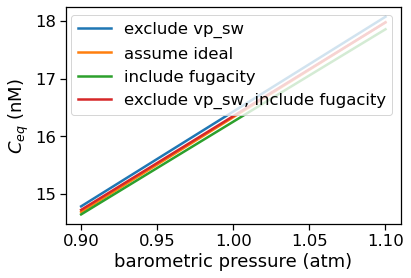

In [17]:
slps = np.linspace(0.9,1.1)
cs1 = []
cs2 = []
cs3 = []
cs4 = []
for slp in slps:
    Ceq1 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=True)
    Ceq2 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=False)
    Ceq3 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=False, nonideal=False)
    Ceq4 = N2OCeq(33, 0, slp = slp, xn2o=338e-9, watervapor=False, nonideal=True)
    cs1.append(Ceq1)
    cs2.append(Ceq2)
    cs3.append(Ceq3)
    cs4.append(Ceq4)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(cs3), label = "exclude vp_sw")
ax.plot(slps, np.array(cs2), label = "assume ideal")
ax.plot(slps, np.array(cs1), label = "include fugacity")
ax.plot(slps, np.array(cs4), label = "exclude vp_sw, include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$C_{eq}$ (nM)")
plt.show()

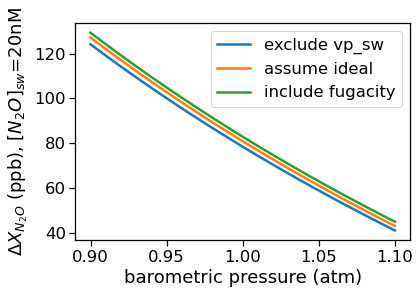

In [18]:
slps = np.linspace(0.9,1.1)
x1 = []
x2 = []
x3 = []
for slp in slps:
    xN2O1 = xN2Osw(33, 0, 20, slp = slp, watervapor=True, nonideal=True)
    xN2O2 = xN2Osw(33, 0, 20, slp = slp, watervapor=True, nonideal=False)
    xN2O3 = xN2Osw(33, 0, 20, slp = slp, watervapor=False, nonideal=False)
    x1.append(xN2O1)
    x2.append(xN2O2)
    x3.append(xN2O3)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(x3)-333, label = "exclude vp_sw")
ax.plot(slps, np.array(x2)-333, label = "assume ideal")
ax.plot(slps, np.array(x1)-333, label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$\Delta X_{N_2O}$ (ppb), $[N_2O]_{sw}$=20nM")
plt.show()

Text(0.5, 0, 'potential temperature ($\\degree C$)')

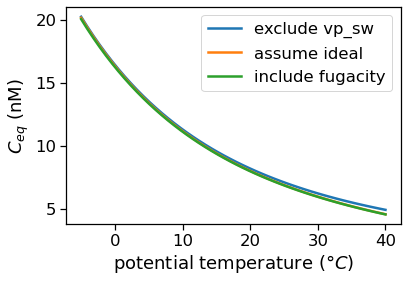

In [19]:
temps = np.linspace(-5,40)
cs1 = []
cs2 = []
cs3 = []
cdiff = []
for t in temps:
    Ceq1 = N2OCeq(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=True)
    Ceq2 = N2OCeq(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=False)
    Ceq3 = N2OCeq(33, t, slp = 1.0, xn2o=338e-9, watervapor=False, nonideal=False)
    cs1.append(Ceq1)
    cs2.append(Ceq2)
    cs3.append(Ceq3)
    cdiff.append(Ceq2 - Ceq1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(cs3), label = "exclude vp_sw")
ax.plot(temps, np.array(cs2), label = "assume ideal")
ax.plot(temps, np.array(cs1), label = "include fugacity")
ax.legend()
ax.set_ylabel("$C_{eq}$ (nM)")
ax.set_xlabel("potential temperature ($\degree C$)")

Text(0.5, 0, 'potential temperature ($\\degree C$)')

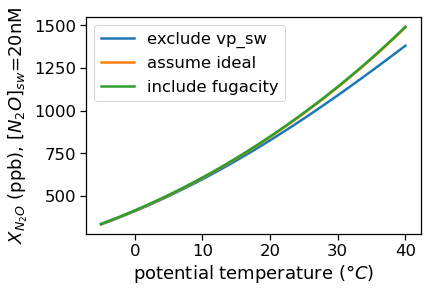

In [20]:
temps = np.linspace(-5,40)
x1 = []
x2 = []
x3 = []
for t in temps:
    xN2O1 = xN2Osw(33, t, 20, slp = 1.0, watervapor=True, nonideal=True)
    xN2O2 = xN2Osw(33, t, 20, slp = 1.0, watervapor=True, nonideal=False)
    xN2O3 = xN2Osw(33, t, 20, slp = 1.0, watervapor=False, nonideal=False)
    x1.append(xN2O1)
    x2.append(xN2O2)
    x3.append(xN2O3)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(x3), label = "exclude vp_sw")
ax.plot(temps, np.array(x2), label = "assume ideal")
ax.plot(temps, np.array(x1), label = "include fugacity")
ax.legend()
ax.set_ylabel("$X_{N_2O}$ (ppb), $[N_2O]_{sw}$=20nM")
ax.set_xlabel("potential temperature ($\degree C$)")

Text(0, 0.5, '$pN_2O_{atm}$')

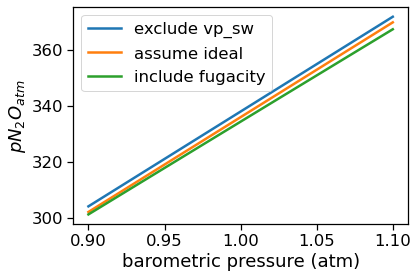

In [21]:
slps = np.linspace(0.9,1.1)
p1s = []
p2s = []
p3s = []
cdiff1 = []
cdiff2 = []
for slp in slps:
    pN2Oatm1 = pN2Oatm(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, 0, slp = slp, xn2o=338e-9, watervapor=False, nonideal=False)
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(p3s), label = "exclude vp_sw")
ax.plot(slps, np.array(p2s), label = "assume ideal")
ax.plot(slps, np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$pN_2O_{atm}$")

Text(0, 0.5, '$\\Delta pN_2O$, $[N_2O]_{sw}$=20 nM')

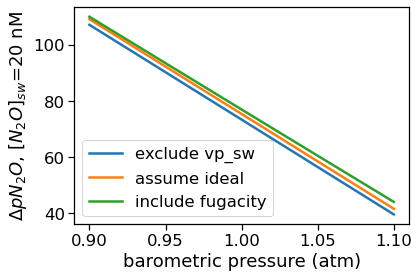

In [22]:
slps = np.linspace(0.9,1.1)
p1s = []
p2s = []
p3s = []
p4s = []
cdiff1 = []
cdiff2 = []
for slp in slps:
    pN2Oatm1 = pN2Oatm(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, 0, slp = slp, xn2o=338e-9, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, 0, slp = slp, xn2o=338e-9, watervapor=False, nonideal=False)
    p4s.append(pN2Osw(33,0,20))
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(slps, np.array(p4s) - np.array(p3s), label = "exclude vp_sw")
ax.plot(slps, np.array(p4s) - np.array(p2s), label = "assume ideal")
ax.plot(slps, np.array(p4s) - np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("barometric pressure (atm)")
ax.set_ylabel("$\Delta pN_2O$, $[N_2O]_{sw}$=20 nM")

Text(0, 0.5, '$pN_2O_{atm}$')

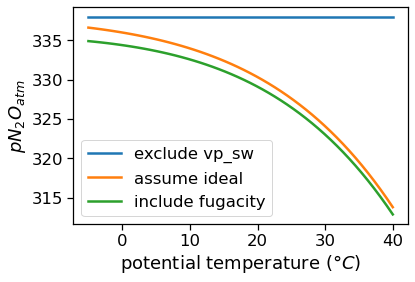

In [23]:
temps = np.linspace(-5, 40)
p1s = []
p2s = []
p3s = []
cdiff1 = []
cdiff2 = []
for t in temps:
    pN2Oatm1 = pN2Oatm(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, t, slp = 1.0, xn2o=338e-9, watervapor=False, nonideal=False)
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(p3s), label = "exclude vp_sw")
ax.plot(temps, np.array(p2s), label = "assume ideal")
ax.plot(temps, np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("potential temperature ($\degree C$)")
ax.set_ylabel("$pN_2O_{atm}$")

Text(0, 0.5, '$\\Delta pN_2O$, $[N_2O]_{sw}$=20 nM')

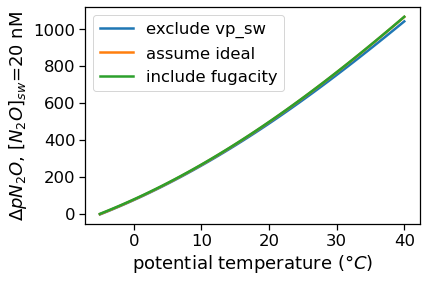

In [24]:
temps = np.linspace(-5, 40)
p1s = []
p2s = []
p3s = []
p4s = []
cdiff1 = []
cdiff2 = []
for t in temps:
    pN2Oatm1 = pN2Oatm(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=True)
    pN2Oatm2 = pN2Oatm(33, t, slp = 1.0, xn2o=338e-9, watervapor=True, nonideal=False)
    pN2Oatm3 = pN2Oatm(33, t, slp = 1.0, xn2o=338e-9, watervapor=False, nonideal=False)
    p4s.append(pN2Osw(33,t,20))
    p1s.append(pN2Oatm1)
    p2s.append(pN2Oatm2)
    p3s.append(pN2Oatm3)
    cdiff1.append(pN2Oatm2 - pN2Oatm1)
    cdiff2.append(pN2Oatm3 - pN2Oatm1)
    
fig, ax = plt.subplots()
ax.plot(temps, np.array(p4s) - np.array(p3s), label = "exclude vp_sw")
ax.plot(temps, np.array(p4s) - np.array(p2s), label = "assume ideal")
ax.plot(temps, np.array(p4s) - np.array(p1s), label = "include fugacity")
ax.legend()
ax.set_xlabel("potential temperature ($\degree C$)")
ax.set_ylabel("$\Delta pN_2O$, $[N_2O]_{sw}$=20 nM")

In [25]:
p = 1 * units.atm
T = 20 * units.degC
rh = 1.0
xH2O = mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')
density(p, T, xH2O * units('g/kg'))

1.2041180947480494 <Unit('kilogram / meter ** 3')>

In [26]:
p = 1000. * units.hPa
T = 28.1 * units.degC
rh = .65
mixing_ratio_from_relative_humidity(p, T, rh).to('g/kg')

15.764696916938787 <Unit('gram / kilogram')>

In [27]:
def kinematic_viscosity_air_checkunits(air_temperature, air_density):
    """
    Calculate the kinematic viscosity of air given the air temperature, pressure, and 100% relative humidity.

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        pressure (float): Pressure in atm.

    Returns:
        float: Kinematic viscosity of air in m^2/s.
    """
    # Convert air temperature to Kelvin
    T = air_temperature + 273.15
    
    rho_a = air_density

    # absolute viscosity of air (Sutherland's formula)
    mu_a = (1.458e-6 * T**1.5) / (T + 110.4) * units('kg/m/s') # units are kg/m/s
    
    # kinematic viscosity of air
    nu_a = mu_a / rho_a # units are m2/s
    
    return mu_a, nu_a

# Example usage:
air_temperature = 20  # degrees Celsius
pressure = 1          # atm

# Calculate kinematic viscosity of air
mu_a, nu_a = kinematic_viscosity_air_checkunits(20,1.22 * units('kg/m3'))
print("Kinematic viscosity of air:", nu_a)

Kinematic viscosity of air: 1.4863982640564129e-05 meter ** 2 / second


In [28]:
mu_a.units

<Unit('kilogram / meter / second')>

In [29]:
nu_a.units

<Unit('meter ** 2 / second')>

In [30]:
def kinematic_viscosity_air(air_temperature, air_density):
    """
    Calculate the kinematic viscosity of air given the air temperature, pressure, and 100% relative humidity.

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        pressure (float): Pressure in atm.

    Returns:
        float: Kinematic viscosity of air in m^2/s.
    """
    # Convert air temperature to Kelvin
    T = air_temperature + 273.15
    
    rho_a = air_density # units are kg/m3
    
    # absolute viscosity of air (Sutherland's formula)
    mu_a = (1.458e-6 * T**1.5) / (T + 110.4) # units are kg/m/s
    
    # kinematic viscosity of air
    nu_a = mu_a / rho_a # units are m2/s
    
    return mu_a, nu_a

# Example usage:
air_temperature = 20  # degrees Celsius
pressure = 1          # atm

# Calculate kinematic viscosity of air
mu_a, nu_a = kinematic_viscosity_air(20,1.22)
print("Kinematic viscosity of air:", nu_a)

Kinematic viscosity of air: 1.4863982640564129e-05


In [31]:
def air_side_Schmidt_number_checkunits(air_temperature, air_density, gas=None, calculate=True):
    """
    Calculate the air-side Schmidt number for nitrous oxide (N2O).

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        sea_level_pressure (float): Sea level pressure in atm.
        rh (float): relative humidity (default: 1)
        gas: formula for gas (H2O, CO2, CH4, CO, SO2, O3, NH3, or N2O), formatted as a string, e.g. 'He'
        calculate: if True, calculate Schmidt number from diffusivity and kinematic viscosity of air;
                   if False, use default value from lookup table

    Returns:
        float: Air-side Schmidt number for nitrous oxide (N2O).
    """
    # Coefficients of diffusivity (cm2/s) of selected gases in air, Massman 1998
    diffusivities = {
        'H2O': 0.2178,
        'CO2': 0.1381,
        'CH4': 0.1952,
        'CO': 0.1807,
        'SO2': 0.1089,
        'O3': 0.1444,
        'NH3': 0.1978,
        'N2O': 0.1436,
    }
    
    # empirical values from de Richter et al., 2017
    schmidt_dict = {
        'H2O': 0.61,
        'CH4': 0.69,
        'N2O': 0.93,
    }

    # can calculate Schmidt number for gases that we have the diffusivities for
    if (gas in diffusivities.keys())&(calculate==True):
        # Convert air temperature to Kelvin
        T = air_temperature + 273.15
        # Constants for N2O
        molecular_diffusivity = diffusivities[gas]*1e-4 * units('m2/s')  # convert from cm^2/s to m2/s
        # Calculate air-side Schmidt number
        mu_a, nu_a = kinematic_viscosity_air_checkunits(air_temperature, air_density) # kg/m/s, m2/s
        ScA = nu_a / molecular_diffusivity # dimensionless
    # or look up an empirical value
    elif (gas in schmidt_dict.keys())&(calculate==False):
        ScA = schmidt_dict[gas] * units('dimensionless')
    # or just use default value of 0.9 for all other cases
    else:
        ScA = 0.9 * units('dimensionless')
    
    return ScA

# Example usage:
air_temperature = 20  # degrees Celsius
rhoa = 1.22 * units('kg/m3') # kg/m3
gas = "N2O"
ScA = air_side_Schmidt_number_checkunits(air_temperature, rhoa, gas=gas, calculate=True)
print(f"Air-side Schmidt number for {gas}: {ScA:.4}")

Air-side Schmidt number for N2O: 1.035 dimensionless


In [32]:
def air_side_Schmidt_number(air_temperature, air_density, gas=None, calculate=True):
    """
    Calculate the air-side Schmidt number for nitrous oxide (N2O).

    Parameters:
        air_temperature (float): Air temperature in degrees Celsius.
        sea_level_pressure (float): Sea level pressure in atm.
        rh (float): relative humidity (default: 1)
        gas: formula for gas (H2O, CO2, CH4, CO, SO2, O3, NH3, or N2O), formatted as a string, e.g. 'He'
        calculate: if True, calculate Schmidt number from diffusivity and kinematic viscosity of air;
                   if False, use default value from lookup table

    Returns:
        float: Air-side Schmidt number for nitrous oxide (N2O).
    """
    # Coefficients of diffusivity (cm2/s) of selected gases in air, 
    diffusivities = {
        'H2O': 0.2178, # Massman 1998
        'CO2': 0.1381, # Massman 1998
        'CH4': 0.1952, # Massman 1998
        'CO': 0.1807, # Massman 1998
        'SO2': 0.1089, # Massman 1998
        'O3': 0.1444, # Massman 1998
        'NH3': 0.1978, # Massman 1998
        'N2O': 0.1436, # Massman 1998
    }
    
    # empirical values from de Richter et al., 2017
    schmidt_dict = {
        'H2O': 0.61,
        'CH4': 0.69,
        'N2O': 0.93,
    }

    # can calculate Schmidt number for gases that we have the diffusivities for
    if (gas in diffusivities.keys())&(calculate==True):
        # Convert air temperature to Kelvin
        T = air_temperature + 273.15
        # Constants for N2O
        molecular_diffusivity = diffusivities[gas]*1e-4  # convert from cm^2/s to m2/s
        # Calculate air-side Schmidt number
        mu_a, nu_a = kinematic_viscosity_air(air_temperature, air_density)  # kg/m/s, m2/s
        ScA = nu_a / molecular_diffusivity # dimensionless
    # or look up an empirical value
    elif (gas in schmidt_dict.keys())&(calculate==False):
        ScA = schmidt_dict[gas]
    # or just use default value of 0.9 for all other cases
    else:
        ScA = 0.9
    
    return ScA

# Example usage:
air_temperature = 20  # degrees Celsius
rhoa = 1.22  # kg/m3
gas = "CO2"
ScA = air_side_Schmidt_number(air_temperature, rhoa, gas=gas, calculate=True)
print(f"Air-side Schmidt number for {gas}: {ScA:.4}")

Air-side Schmidt number for CO2: 1.076


In [33]:
def xH2O_from_rh(SP,pt,slp=1.0,rh=1.0):
    
    # Calculate vapor pressure at moist interface
    ph2oveq = vpress_sw(SP,pt) # atm
    ph2ov = rh * ph2oveq # atm
    
    molwt_h2o = 18.01528 # g/mol
    molwt_air = 28.96 # g/mol
    
    # Calculate mixing ratio
    mixing_ratio = molwt_h2o / molwt_air * ph2ov / (slp - ph2ov) * 1000  # Convert to g/kg

    return mixing_ratio

In [34]:
# take salinity into account
xH2O_from_rh(33,0,slp=1.0,rh=1.0)

3.7085260553248776

In [35]:
# don't take salinity into account
xH2O_from_rh(0,0,slp=1.0,rh=1.0)

3.775252511271652

In [36]:
# metpy function
mixing_ratio_from_relative_humidity(1 * units.atm, 0 * units.degC, 1.0).to('g/kg')

3.774458549148858 <Unit('gram / kilogram')>

In [37]:
def rh_from_dewpoint_SP_pt(SP, pt, dewpoint):
    # Calculate vapor pressure at moist interface
    es = vpress_sw(SP,pt) # atm
    e = vpress_sw(SP,dewpoint) # atm
    
    rh = e/es
    
    return rh

In [38]:
def rh_from_dewpoint_t2m(t2m, dewpoint):
    # Calculate vapor pressure at moist interface
    es = vpress_w(t2m) # atm
    e = vpress_w(dewpoint) # atm
    
    rh = e/es
    
    return rh

In [39]:
rh_from_dewpoint_SP_pt(33,30,20)

0.5507977020398768

In [40]:
rh_from_dewpoint_t2m(30, 20)

0.5507977020398768

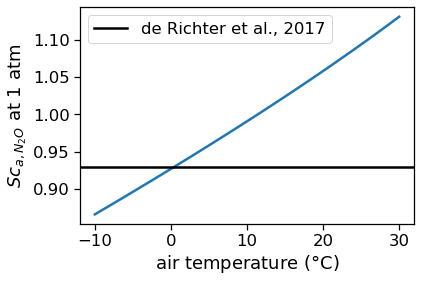

In [41]:
temps = np.linspace(-10,30)
schmidts = []
for t in temps:
    # calculate mixing ratio of water vapor in air
    xH2O = xH2O_from_rh(33,t,slp=1.0,rh=1.0)

    # Calculate density of air
    rhoa = density(1 * units.atm, t * units.degC, xH2O * units('g/kg')) # kg/m3
    
    # Calculate Schmidt number
    ScA = air_side_Schmidt_number_checkunits(t, rhoa, gas="N2O", calculate=True)
    schmidts.append(float(ScA))
    
fig, ax = plt.subplots()
ax.plot(temps, schmidts, label = None)
ax.set_xlabel("air temperature ($\degree$C)")
ax.set_ylabel("$Sc_{a,N_2O}$ at 1 atm")
ax.axhline(0.93, color='k', label = "de Richter et al., 2017")
ax.legend()

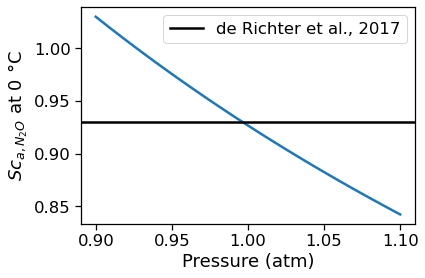

In [42]:
pressures = np.linspace(0.9,1.1)
schmidts = []
for p in pressures:
    # calculate mixing ratio of water vapor in air
    xH2O = xH2O_from_rh(33,0,slp=p,rh=1.0)

    # Calculate density of air
    rhoa = density(p * units.atm, 0 * units.degC, xH2O * units('g/kg')) # kg/m3
    
    # Calculate Schmidt number
    ScA = air_side_Schmidt_number_checkunits(0, rhoa, gas="N2O", calculate=True)
    schmidts.append(float(ScA))
    
fig, ax = plt.subplots()
ax.plot(pressures, schmidts)
ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("$Sc_{a,N_2O}$ at 0 $\degree$C")
ax.axhline(0.93, color='k', label = "de Richter et al., 2017")
ax.legend()

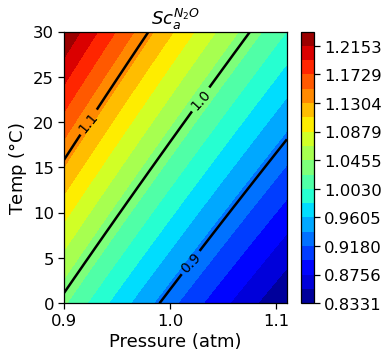

In [43]:
xmin = 0.9
xmax = 1.1
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        # calculate mixing ratio of water vapor in air
        xH2O = mixing_ratio_from_relative_humidity(x[j] * units.atm, y[k] * units.degC, 1.0).to('g/kg') # g/kg

        # Calculate density of air
        rhoa = density(x[j] * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3

        # Calculate Schmidt number
        ScA = air_side_Schmidt_number_checkunits(y[k], rhoa, gas="N2O", calculate=True)
        z[k,j] = float(ScA)
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{N_2O}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

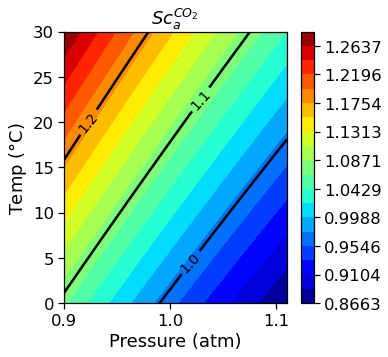

In [44]:
xmin = 0.9
xmax = 1.1
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        # calculate mixing ratio of water vapor in air
        xH2O = mixing_ratio_from_relative_humidity(x[j] * units.atm, y[k] * units.degC, 1.0).to('g/kg') # g/kg

        # Calculate density of air
        rhoa = density(x[j] * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3

        # Calculate Schmidt number
        ScA = air_side_Schmidt_number_checkunits(y[k], rhoa, gas="CO2", calculate=True)
        z[k,j] = float(ScA)
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{CO_2}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

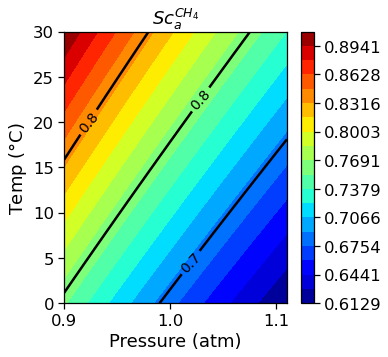

In [45]:
xmin = 0.9
xmax = 1.1
dx = 0.01
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        # calculate mixing ratio of water vapor in air
        xH2O = mixing_ratio_from_relative_humidity(x[j] * units.atm, y[k] * units.degC, 1.0).to('g/kg') # g/kg

        # Calculate density of air
        rhoa = density(x[j] * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3

        # Calculate Schmidt number
        ScA = air_side_Schmidt_number_checkunits(y[k], rhoa, gas="CH4", calculate=True)
        z[k,j] = float(ScA)
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("Pressure (atm)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{CH_4}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

In [44]:
@match_args_return
def schmidt_W92(pt,*,gas=None,sw=True):
    """Schmidt number @ 35 psu based on Wanninkhof 1992 Table A1

    Args:
        pt ([array like]): potential temperature  [degree C]
        gas ([string]): abbreviation for gas. Defaults to None.
        sw (bool, optional): if True, then calculates for SP = 35, of false, 
            calculates for fresh water. Defaults to True.

    Raises:
        ValueError: [description]

    Returns:
        [type]: Schmidt number [dimensionless]
    """
    W92_LIST = ('HE','NE','AR','O2','CH4','CO2','N2','KR','N2O','RN','SF6','CCL2','CCL3')
    g_up = gas.upper()
    if sw:
        A_dict = {
            'HE': (410.14, 20.503, 0.53175, 0.0060111),
            'NE': (855.1, 46.299, 1.254, 0.01449),
            'AR': (1909.1, 125.09, 3.9012, 0.048953),
            'O2': (1953.4, 128.00, 3.9918, 0.050091),
            'CH4': (2039.2, 120.31, 3.4209, 0.040437),
            'CO2': (2073.1, 125.62, 3.6276, 0.043219),
            'N2': (2206.1, 144.86, 4.5413, 0.056988),
            'KR': (2205.0, 135.71, 3.9549, 0.047339),
            'N2O': (2301.1, 151.1, 4.7364, 0.059431),
            'RN': (3412.8, 224.30, 6.7954, 0.08300),
            'SF6': (3531.6, 231.40, 7.2168, 0.090558),
            'CCL2': (3713.2, 243.30, 7.5879, 0.095215),
            'CCL3': (4039.8, 264.70, 8.2552, 0.10359)
        } if sw else {
            'HE': (377.09, 19.154, 0.50137, 0.005669),
            'NE': (764, 42.234, 1.1581, 0.013405),
            'AR': (1759.7, 117.37, 3.6959, 0.046527),
            'O2': (1800.6, 120.10, 3.7818, 0.047608),
            'CH4': (1897.8, 114.28, 3.2902, 0.039061),
            'CO2': (1911.1, 118.11, 3.4527, 0.041320),
            'N2': (1970.7, 131.45, 4.1390, 0.052106),
            'KR': (2032.7, 127.55, 3.7621, 0.045236),
            'N2O': (2055.6, 137.11, 4.3173, 0.054350),
            'RN': (3146.1, 210.48, 6.4486, 0.079135),
            'SF6': (3255.3, 217.13, 6.8370, 0.086070),
            'CCL2': (3422.7, 228.30, 7.1886, 0.090496),
            'CCL3': (3723.7, 248.37, 7.8208, 0.098455)
        }

    if g_up in A_dict.keys():
        A = A_dict[g_up]
    else:
        raise ValueError(f"gas {g_up} does not match one of {A_dict.keys()}")

    Sc = A[0] - A[1]*pt + A[2]*pt**2 - A[3]*pt**3
    return Sc

In [45]:
@match_args_return
def schmidt(SP,pt,*,gas=None, schmidtcalc=None):
    GAS_LIST = ('HE','NE','AR','KR','XE','N2','O2','CH4','N2','CO2')
    W14_LIST = ('CO2','N2O','CH4','RN','SF6','DMS','CFC12','CFC11','CH3BR','CCL4')
    W92_LIST = ('HE','NE','AR','O2','CH4','CO2','N2','KR','N2O','RN','SF6','CCL2','CCL3')
    
    g_up = gas.upper()
    
    if schmidtcalc is None:
        try:
            if g_up in GAS_LIST:
                return visc(SP, pt) / diff(SP, pt, gas=gas)
            elif g_up in W14_LIST:
                return schmidt_W14(pt, gas=gas, sw=True)
            elif g_up in W92_LIST:
                return schmidt_W92(pt, gas=gas, sw=True)
            else:
                raise ValueError(f"gas {g_up} does not match one of {set(GAS_LIST + W14_LIST + W92_LIST)}")
        except ValueError:
            raise ValueError(f"gas {g_up} does not match one of {set(GAS_LIST + W14_LIST + W92_LIST)}")
    
    if g_up:
        if g_up not in GAS_LIST and g_up not in W14_LIST and g_up not in W92_LIST:
            raise ValueError(f"gas {g_up} does not match one of {set(GAS_LIST + W14_LIST + W92_LIST)}")
        
        if g_up in GAS_LIST and schmidtcalc == "viscdiff":
            return visc(SP, pt) / diff(SP, pt, gas=gas)
        
        if g_up in W14_LIST and schmidtcalc == "W14":
            return schmidt_W14(pt, gas=gas, sw=True)
        
        if g_up in W92_LIST and schmidtcalc == "W92":
            return schmidt_W92(pt, gas=gas, sw=True)
        
        if schmidtcalc == "viscdiff":
            return visc(SP, pt) / diff(SP, pt, gas=gas)
        
        if schmidtcalc == "W14":
            return schmidt_W14(pt, gas=gas, sw=True)
        
        if schmidtcalc == "W92":
            return schmidt_W92(pt, gas=gas, sw=True)
    
    raise ValueError(f"Invalid combination of gas {g_up} and schmidtcalc {schmidtcalc}")

In [46]:
schmidt(33,20, gas="CO2", schmidtcalc="W92")

665.9879999999998

In [47]:
schmidt_W14(20,gas='N2O',sw=True)

697.0159999999996

In [48]:
schmidt_W92(20,gas='N2O',sw=True)

698.2119999999999

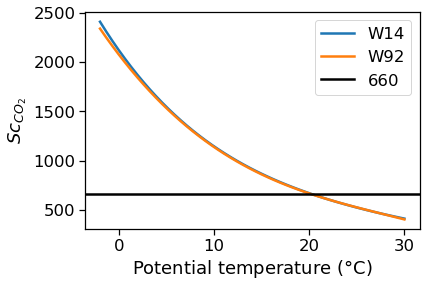

In [49]:
temps = np.linspace(-2,30)
schmidt14 = []
schmidt92 = []
for t in temps:
    schmidt14.append(schmidt_W14(t,gas='CO2',sw=True))
    schmidt92.append(schmidt_W92(t,gas='CO2',sw=True))
    
fig, ax = plt.subplots()
ax.plot(temps, schmidt14, label = "W14")
ax.plot(temps, schmidt92, label = "W92")
ax.set_xlabel("Potential temperature ($\degree$C)")
ax.set_ylabel("$Sc_{CO_2}$")
ax.axhline(660, label = "660", color = "k")
ax.legend()

In [50]:
@match_args_return
def L13unitcheck(C,u10,SP,pt,*,slp=1.0,gas=None,rh=1.0,chi_atm=None, air_temperature=None, calculate_Sca=True, schmidtcalc=None):
    # -------------------------------------------------------------------------
    # Convert inputs to arrays to be able to use metpy.units
    # -------------------------------------------------------------------------
    C = np.array(C)
    u10 = np.array(u10)
    SP = np.array(SP)
    pt = np.array(pt)
    slp = np.array(slp)
    rh = np.array(rh)
    if chi_atm is not None:
        chi_atm = np.array(chi_atm)
    if air_temperature is not None:
        air_temperature = np.array(air_temperature)
    # -------------------------------------------------------------------------
    # Conversion factors & assign units
    # -------------------------------------------------------------------------
    m2cm = 100 * units('cm/m') # cm in a meter
    h2s = 3600 * units('s/hr') # sec in hour
    atm2pa = 101325.0 * units('kg/(m s2 atm)') # express in terms of SI base units: 1 Pa = kg/m/s2
    R = 8.3144598 * units('kg*m2/(s2 mol K)') # express in terms of SI base units: 1 J = kg*m2/s2
    # -------------------------------------------------------------------------
    # Calculate water vapor pressure and adjust sea level pressure
    # -------------------------------------------------------------------------

    # if humidity is not provided, set to 1 for all values
    ph2oveq = vpress_sw(SP,pt) * units('atm')
    ph2ov = rh * ph2oveq

    # slpc = (observed dry air pressure)/(reference dry air pressure)
    slp_corr = (slp*units.atm - ph2ov) /(1*units.atm - ph2oveq)
    
    # -------------------------------------------------------------------------
    # Calculate air density and Schmidt number if air temperature is not None
    # -------------------------------------------------------------------------
    if air_temperature is not None:
        # Convert air temperature to Kelvin
        T = (air_temperature + 273.15)

        # calculate mixing ratio of water vapor in air
        #xH2O = mixing_ratio_from_relative_humidity(slp * units.atm, air_temperature * units.degC, rh).to('g/kg')
        xH2O = xH2O_from_rh(SP,pt,slp=slp,rh=rh)

        # Calculate density of air
        rhoa = density(slp * units.atm, air_temperature * units.degC, xH2O * units('g/kg'))

        # air-side schmidt number
        ScA = air_side_Schmidt_number_checkunits(air_temperature, rhoa, gas=gas, calculate=calculate_Sca)

    else:
        rhoa = 1.225 * units('kg/m3') # density of air
        ScA = 0.9 * units('dimensionless')
    # -------------------------------------------------------------------------
    # Parameters for COARE 3.0 calculation - diffusive gas exchange
    # -------------------------------------------------------------------------

    # Calculate potential density at surface
    SA = SP * 35.16504 / 35
    CT = CT_from_pt(SA,pt)
    rhow = rho(SA,CT,0*CT)*units('kg/m3') # density of water

    lam = 13.3 # numerator in Fairall et al., 2011 eqn. (14). Not sure about units but Lam/A/phi is dimensionless
    A = 1.3 # constant, determined empirically by Fairall et al. (2011)
    phi = 1 # buoyancy term. Except for light wind cases, phi=1 (Fairall et al., 2011)
    tkt = 0.01 * units('m') # molecular sublayer thickness, ~1 mm (Fairall et al., 2011)
    hw = lam /A / phi # eqn. 14 of Fairall et al., 2011
    ha = lam # defined as 13.3 in Fairall et al., 2011
    zw = 0.5 * units('m')
    za = 1.0 # atmospheric measurement height - should this be 2 if the air temp. and dewpoint are from 2m?
    kappa = 0.4 # defined as 0.4 in Fairall et al., 2011

    # -------------------------------------------------------------------------
    # Calculate gas physical properties
    # -------------------------------------------------------------------------
    if chi_atm is None:
        xG = air_mol_fract(gas=gas)
    else:
        xG = chi_atm

    k0 = sol_SP_pt(SP,pt,gas=gas,slp=slp,rh=rh,chi_atm=xG, units="mM")
    f = patm(SP,pt,gas=gas,slp=slp,rh=rh,chi_atm=xG,units="atm")
    Geq = k0*f * units('mol/m3')

    T = pt * units.degC
    T = T.to('K')
    alc0 = (Geq / (1 * units('atm') * atm2pa)) * R * (pt+K0) * units('K') # original: I think this assumes the barometric pressure is 1 atm?
    alc = (Geq / (slp * units('atm') * atm2pa)) * R * T # dividing by slp makes alc dimensionless

    Gsat = C * units('mol/m3') / Geq
    ScW = schmidt(SP,pt,gas=gas, schmidtcalc=schmidtcalc)

    # -------------------------------------------------------------------------
    # Calculate COARE 3.0 and gas transfer velocities
    # -------------------------------------------------------------------------
    # ustar
    # eqns. 12 and 13 of Liang et al., 2013
    cd10 = cdlp81(u10)
    ustar = u10 * np.sqrt(cd10)
    ustar2 = u10 * np.sqrt(rhoa*cd10/rhow) # L13 equation 12 is actually u10*np.sqrt(rhoa*cd10/rhow) but this doesn't work as well
    
    # water-side ustar
    ustarw = ustar / np.sqrt(rhow / rhoa)

    # water-side resistance to transfer
    # eqn. 13 of Fairall et al., 2011
    rwt = np.sqrt(rhow / rhoa) * (hw * np.sqrt(ScW)+(np.log(zw / tkt) / kappa)) # Fairall et al. 2011 define k as 0.4

    # air-side resistance to transfer
    # eqn. 15 of Fairall et al., 2011
    rat = ha * np.sqrt(ScA) + za / np.sqrt(cd10) - 5 + 0.5 * np.log(ScA) / kappa

    # diffusive gas transfer coefficient (L13 eqn 9/Fairall 2011 eqn. 11)
    Ks = ustar / (rwt + rat * alc) * units('m/s')

    # bubble transfer velocity (L13 eqn 14)
    Kb = 1.98e6 * ustarw**2.76 * (ScW / 660)**(-2/3) * units('cm/hr') / (m2cm * h2s)
    
    Kt = Ks + Kb

    # overpressure dependence on windspeed (L13 eqn 16)
    dP = 1.5244 * ustarw**1.06 * units('dimensionless') # equivalent to 152.44ustarw**1.06 %

    # -------------------------------------------------------------------------
    # Calculate air-sea fluxes
    # -------------------------------------------------------------------------

    Fd = Ks * Geq * (slp_corr - Gsat) # Fs in L13 eqn 3
    Fp = Kb * Geq * ((1+dP) * slp_corr - Gsat) # Fp in L13 eqn 3
    Fc = xG * 5.56 * ustarw ** 3.86 * units('mol/(m2 s)') # L13 eqn 15

    # -------------------------------------------------------------------------
    # Calculate steady-state supersaturation
    # -------------------------------------------------------------------------
    # L13 eqn 5
    Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr)

    return (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq)

In [51]:
@match_args_return
def rwtat(C,u10,SP,pt,*,slp=1.0,gas=None,rh=1.0,chi_atm=None, air_temperature=None, calculate_Sca=True,schmidtcalc=None):
    # -------------------------------------------------------------------------
    # Convert inputs to arrays
    # -------------------------------------------------------------------------
    C = np.array(C)
    u10 = np.array(u10)
    SP = np.array(SP)
    pt = np.array(pt)
    slp = np.array(slp)
    rh = np.array(rh)
    if chi_atm is not None:
        chi_atm = np.array(chi_atm)
    if air_temperature is not None:
        air_temperature = np.array(air_temperature)
    # -------------------------------------------------------------------------
    # Conversion factors & assign units
    # -------------------------------------------------------------------------
    m2cm = 100 # cm in a meter, cm/m
    h2s = 3600# sec in hour, s/hr
    atm2pa = 101325.0 # Pa per atm, Pa/atm, 1 Pa = kg/m/s2
    R = 8.3144598 # ideal gas constant, J/(mol K), 1 J = kg*m2/s2
    # -------------------------------------------------------------------------
    # Calculate water vapor pressure and adjust sea level pressure
    # -------------------------------------------------------------------------

    # if humidity is not provided, set to 1 for all values
    ph2oveq = vpress_sw(SP,pt) # atm
    ph2ov = rh * ph2oveq # atm

    # slpc = (observed dry air pressure)/(reference dry air pressure)
    slp_corr = (slp - ph2ov) /(1 - ph2oveq) # dimensionless
    
    # -------------------------------------------------------------------------
    # Calculate air density and Schmidt number if air temperature is not None
    # -------------------------------------------------------------------------
    if air_temperature is not None:
        # Convert air temperature to Kelvin
        T = (air_temperature + 273.15) # K

        # calculate mixing ratio of water vapor in air
        #xH2O = mixing_ratio_from_relative_humidity(slp * units.atm, air_temperature * units.degC, rh).to('g/kg') # g/kg
        xH2O = xH2O_from_rh(SP,pt,slp=slp,rh=rh)

        # Calculate density of air
        rhoa = density(slp * units.atm, air_temperature * units.degC, xH2O * units('g/kg')) # kg/m3
        # drop metpy units for computational efficiency
        rhoa = float(rhoa * units('m3/kg')) # need to non-dimensionalize to drop units

        # air-side schmidt number, dimensionless
        ScA = air_side_Schmidt_number(air_temperature, rhoa, gas=gas, calculate=calculate_Sca)
        xH2O = float(xH2O) # drop metpy units for computational efficiency
        ScA = float(ScA)

    else:
        rhoa = 1.225 # default density of air, kg/m3
        ScA = 0.9 # default air Schmidt number, dimensionless
    # -------------------------------------------------------------------------
    # Parameters for COARE 3.0 calculation - diffusive gas exchange
    # -------------------------------------------------------------------------

    # Calculate potential density at surface
    SA = SP * 35.16504 / 35 # absolute salinity, psu
    CT = CT_from_pt(SA,pt) # conservative temperature, degrees C
    rhow = rho(SA,CT,0*CT) # density of water, kg/m3

    lam = 13.3 # numerator in Fairall et al., 2011 eqn. (14). Not sure about units but Lam/A/phi is dimensionless
    A = 1.3 # constant, determined empirically by Fairall et al. (2011)
    phi = 1 # buoyancy term. Except for light wind cases, phi=1 (Fairall et al., 2011)
    tkt = 0.01 # molecular sublayer thickness, ~1 mm (Fairall et al., 2011), units in meters
    hw = lam /A / phi # eqn. 14 of Fairall et al., 2011
    ha = lam # defined as 13.3 in Fairall et al., 2011
    zw = 0.5 # units in meters
    za = 1.0 # atmospheric measurement height
    kappa = 0.4 # defined as 0.4 in Fairall et al., 2011

    # -------------------------------------------------------------------------
    # Calculate gas physical properties
    # -------------------------------------------------------------------------
    if chi_atm is None:
        xG = air_mol_fract(gas=gas) # mol gas/mol dry air
    else:
        xG = chi_atm
    k0 = sol_SP_pt(SP,pt,gas=gas,slp=slp,rh=rh,chi_atm=xG, units="mM")
    f = patm(SP,pt,gas=gas,slp=slp,rh=rh,chi_atm=xG,units="atm")
    Geq = k0*f

    T = pt + 273.15 # K
    alc0 = (Geq / atm2pa) * R * (pt+K0) # original: I think this assumes the barometric pressure is 1 atm?
    alc = (Geq / (slp * atm2pa)) * R * T # dividing by slp makes alc dimensionless

    Gsat = C / Geq # dimensionless
    ScW = schmidt(SP,pt,gas=gas,schmidtcalc=schmidtcalc) # dimensionless

    # -------------------------------------------------------------------------
    # Calculate COARE 3.0 and gas transfer velocities
    # -------------------------------------------------------------------------
    # ustar
    # eqns. 12 and 13 of Liang et al., 2013
    cd10 = cdlp81(u10) # dimensionless?
    ustar = u10 * np.sqrt(cd10) # m/s. using u10*np.sqrt(rhoa*cd10/rhow) (L13 equation 12) throws everything off
    
    # water-side ustar
    ustarw = ustar / np.sqrt(rhow / rhoa) # m/s

    # water-side resistance to transfer, dimensionless
    # eqn. 13 of Fairall et al., 2011
    rwt = np.sqrt(rhow / rhoa) * (hw * np.sqrt(ScW)+(np.log(zw / tkt) / kappa)) # Fairall et al. 2011 define k as 0.4

    # air-side resistance to transfer, dimensionless
    # eqn. 15 of Fairall et al., 2011
    rat = ha * np.sqrt(ScA) + za / np.sqrt(cd10) - 5 + 0.5 * np.log(ScA) / kappa

    return (rwt, rat)

In [52]:
@match_args_return
def L13(C,u10,SP,pt,*,slp=1.0,gas=None,rh=1.0,chi_atm=None, air_temperature=None, calculate_Sca=True, schmidtcalc=None):
    # -------------------------------------------------------------------------
    # Convert inputs to arrays
    # -------------------------------------------------------------------------
    """
    C = np.array(C)
    u10 = np.array(u10)
    SP = np.array(SP)
    pt = np.array(pt)
    slp = np.array(slp)
    rh = np.array(rh)
    if chi_atm is not None:
        chi_atm = np.array(chi_atm)
    if air_temperature is not None:
        air_temperature = np.array(air_temperature)
    """
    # -------------------------------------------------------------------------
    # Conversion factors & assign units
    # -------------------------------------------------------------------------
    m2cm = 100 # cm in a meter, cm/m
    h2s = 3600# sec in hour, s/hr
    atm2pa = 101325.0 # Pa per atm, Pa/atm, 1 Pa = kg/m/s2
    R = 8.3144598 # ideal gas constant, J/(mol K), 1 J = kg*m2/s2
    # -------------------------------------------------------------------------
    # Calculate water vapor pressure and adjust sea level pressure
    # -------------------------------------------------------------------------

    # if humidity is not provided, set to 1 for all values
    ph2oveq = vpress_sw(SP,pt) # atm
    ph2ov = rh * ph2oveq # atm

    # slpc = (observed dry air pressure)/(reference dry air pressure)
    slp_corr = (slp - ph2ov) /(1 - ph2oveq) # dimensionless
    
    # -------------------------------------------------------------------------
    # Calculate air density and Schmidt number if air temperature is not None
    # -------------------------------------------------------------------------
    if air_temperature is not None:
        # Convert air temperature to Kelvin
        T = (air_temperature + 273.15) # K

        # calculate mixing ratio of water vapor in air
        #xH2O = mixing_ratio_from_relative_humidity(slp * units.atm, air_temperature * units.degC, rh).to('g/kg') # g/kg
        xH2O = xH2O_from_rh(SP,pt,slp=slp,rh=rh)

        # Calculate density of air
        rhoa = density(np.array(slp) * units.atm, np.array(air_temperature) * units.degC, np.array(xH2O) * units('g/kg')) # kg/m3
        # drop metpy units for computational efficiency
        rhoa = rhoa.magnitude

        # air-side schmidt number, dimensionless
        ScA = air_side_Schmidt_number(air_temperature, rhoa, gas=gas, calculate=calculate_Sca)

    else:
        rhoa = 1.225 # default density of air, kg/m3
        ScA = 0.9 # default air Schmidt number, dimensionless
    # -------------------------------------------------------------------------
    # Parameters for COARE 3.0 calculation - diffusive gas exchange
    # -------------------------------------------------------------------------

    # Calculate potential density at surface
    SA = SP * 35.16504 / 35 # absolute salinity, psu
    CT = CT_from_pt(SA,pt) # conservative temperature, degrees C
    rhow = rho(SA,CT,0*CT) # density of water, kg/m3

    lam = 13.3 # numerator in Fairall et al., 2011 eqn. (14). Not sure about units but Lam/A/phi is dimensionless
    A = 1.3 # constant, determined empirically by Fairall et al. (2011)
    phi = 1 # buoyancy term. Except for light wind cases, phi=1 (Fairall et al., 2011)
    tkt = 0.01 # molecular sublayer thickness, ~1 mm (Fairall et al., 2011), units in meters
    hw = lam /A / phi # eqn. 14 of Fairall et al., 2011
    ha = lam # defined as 13.3 in Fairall et al., 2011
    zw = 0.5 # units in meters
    za = 1.0 # atmospheric measurement height
    kappa = 0.4 # defined as 0.4 in Fairall et al., 2011

    # -------------------------------------------------------------------------
    # Calculate gas physical properties
    # -------------------------------------------------------------------------
    if chi_atm is None:
        xG = air_mol_fract(gas=gas) # mol gas/mol dry air
    else:
        xG = chi_atm
    k0 = sol_SP_pt(SP,pt,gas=gas,slp=slp,rh=rh,chi_atm=xG, units="mM")
    f = patm(SP,pt,gas=gas,slp=slp,rh=rh,chi_atm=xG,units="atm")
    Geq = k0*f

    T = pt + 273.15 # K
    alc0 = (Geq / atm2pa) * R * (pt+K0) # original: I think this assumes the barometric pressure is 1 atm?
    alc = (Geq / (slp * atm2pa)) * R * T # dividing by slp makes alc dimensionless

    Gsat = C / Geq # dimensionless
    ScW = schmidt(SP,pt,gas=gas,schmidtcalc=schmidtcalc) # dimensionless

    # -------------------------------------------------------------------------
    # Calculate COARE 3.0 and gas transfer velocities
    # -------------------------------------------------------------------------
    # ustar
    # eqns. 12 and 13 of Liang et al., 2013
    cd10 = cdlp81test(u10) # dimensionless?
    ustar = u10 * np.sqrt(cd10) # m/s. using u10*np.sqrt(rhoa*cd10/rhow) (L13 equation 12) throws everything off
    
    # water-side ustar
    ustarw = ustar / np.sqrt(rhow / rhoa) # m/s

    # water-side resistance to transfer, dimensionless
    # eqn. 13 of Fairall et al., 2011
    rwt = np.sqrt(rhow / rhoa) * (hw * np.sqrt(ScW)+(np.log(zw / tkt) / kappa)) # Fairall et al. 2011 define k as 0.4

    # air-side resistance to transfer, dimensionless
    # eqn. 15 of Fairall et al., 2011
    rat = ha * np.sqrt(ScA) + za / np.sqrt(cd10) - 5 + 0.5 * np.log(ScA) / kappa

    # diffusive gas transfer coefficient (L13 eqn 9/Fairall 2011 eqn. 11)
    Ks = ustar / (rwt + rat * alc) # m/s

    # bubble transfer velocity (L13 eqn 14)
    Kb = 1.98e6 * ustarw**2.76 * (ScW / 660)**(-2/3) / (m2cm * h2s) # m/s
    
    Kt = Ks + Kb

    # overpressure dependence on windspeed (L13 eqn 16)
    # dP = supersaturation at which air-sea flux due to partially dissolved bubbles = 0
    dP = 1.5244 * ustarw**1.06 # percentage

    # -------------------------------------------------------------------------
    # Calculate air-sea fluxes
    # -------------------------------------------------------------------------

    Fd = Ks * Geq * (slp_corr - Gsat) # Fs in L13 eqn 3, units are mol/m2/s
    Fp = Kb * Geq * ((1+dP) * slp_corr - Gsat) # Fp in L13 eqn 3, units are mol/m2/s
    Fc = xG * 5.56 * ustarw ** 3.86 # L13 eqn 15, units are mol/m2/s

    # -------------------------------------------------------------------------
    # Calculate steady-state supersaturation
    # -------------------------------------------------------------------------
    # L13 eqn 5
    # Deq = supersaturation at which the total gas flux between ocean and atmosphere = 0
    # bubble-mediated flux into the ocean is balanced by diffusive flux out of the ocean
    Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage

    return (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq)

In [53]:
def cdlp81test( u10):
    # Calculates drag coefficient from u10, wind speed at 10 m height

    cd = 4.9e-4 + 6.5e-5 * u10
    if (isinstance(cd,float)):
        cd = np.asarray(cd)
    cd = np.where(u10 <= 11, 0.0012, cd)
    cd = np.where(u10 >= 20, 0.0018, cd)
    return cd

#cdlp81test(n2ods.windspeed_m_s)

In [54]:
L13unitcheck(1e-3,20,33,30,gas='N2O',chi_atm=338e-9, air_temperature=30, calculate_Sca=True, rh = 1.0,schmidtcalc="W92")

(-1.2793698809608832e-07 <Unit('mole / meter ** 2 / second')>,
 2.02436106904195e-12 <Unit('mole / meter ** 2 / second')>,
 -3.955777150358768e-07 <Unit('mole / meter ** 2 / second')>,
 0.027110432305573987 <Unit('dimensionless')>,
 0.00012869994876782984 <Unit('meter / second')>,
 0.0005267198385321367 <Unit('meter / second')>,
 426.2229999999993,
 5.928212707511452e-06 <Unit('mole / meter ** 3')>)

In [55]:
rwtat(1e-3,20,33,30,gas='N2O',chi_atm=338e-9, air_temperature=30, calculate_Sca=True, rh = 1.0)

(6610.073734186326, 32.86478359275543)

In [56]:
L13(1e-3,20,33,0,gas='Ar', air_temperature=20, calculate_Sca=True)

(1.2719289731629903e-06,
 6.047863861950425e-08,
 3.4365119205209495e-06,
 0.038306404567162985,
 7.597492975469876e-05,
 0.00027374481694086497,
 1324.3253329690244,
 0.01774143006475536)

In [57]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(1e-3,20,33,0,gas='Ar')
print(Geq)
print(Geq.to('umol/L'))

[0.01774143006475536] mole / meter ** 3
[17.741430064755363] micromole / liter


In [58]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(10e-3,20,33,0,gas='Ar')
Deq

Magnitude,[0.03889072829467852]
Units,dimensionless


In [57]:
%%time
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(1e-6,j,35,k,gas='Ar')
        z[k,j] = Deq*100

/Users/colette/anaconda3/envs/py310_oceml/lib/python3.10/site-packages/pint/facets/plain/quantity.py:998: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)


CPU times: user 8.25 s, sys: 3.6 ms, total: 8.25 s
Wall time: 8.3 s


In [57]:
%%time
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='Ar')
        z[k,j] = Deq*100

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7030/631916495.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


CPU times: user 985 ms, sys: 3.78 ms, total: 989 ms
Wall time: 1.02 s


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8031/1855667679.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8031/1855667679.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


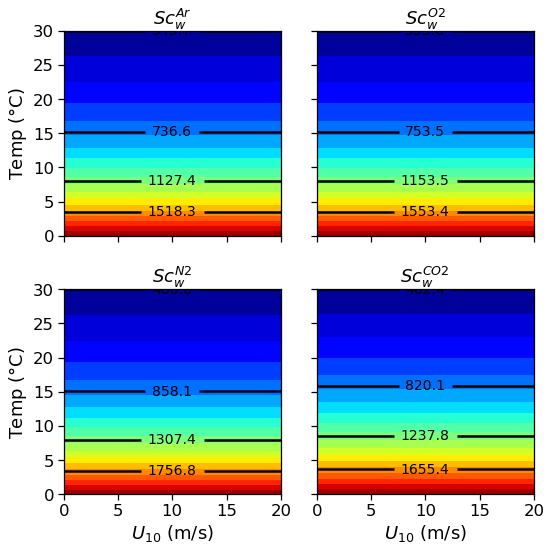

In [74]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = ScW
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$Sc_w^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_10191/631916495.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_10191/631916495.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


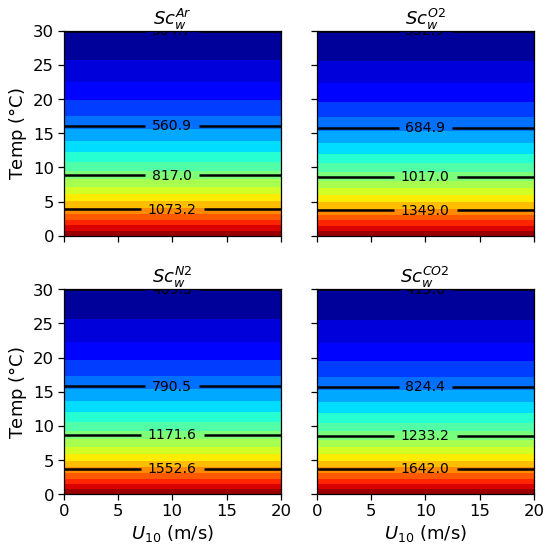

In [61]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = ScW
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$Sc_w^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_10191/631916495.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_10191/631916495.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


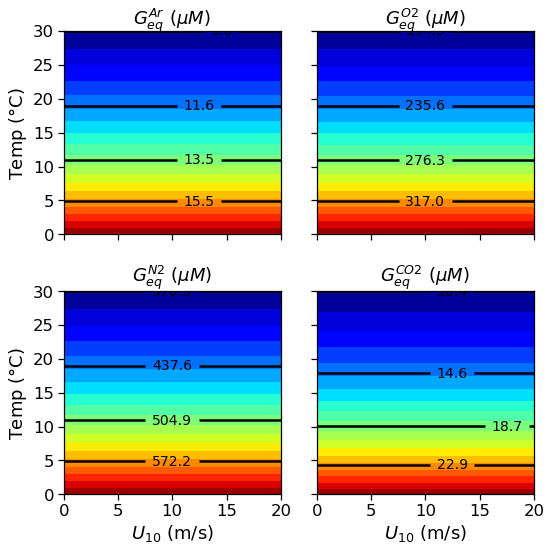

In [62]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = Geq*1000
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$G_{{eq}}^{{{gases[i]}}}\ (\mu M)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

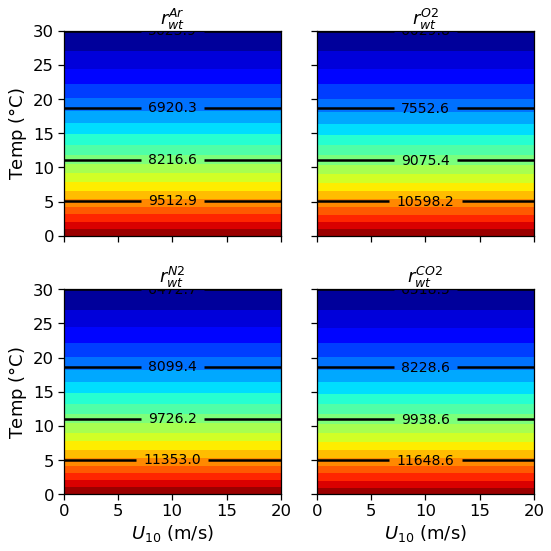

In [132]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (rwt, rat) = rwtat(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = rwt
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$r_{{wt}}^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

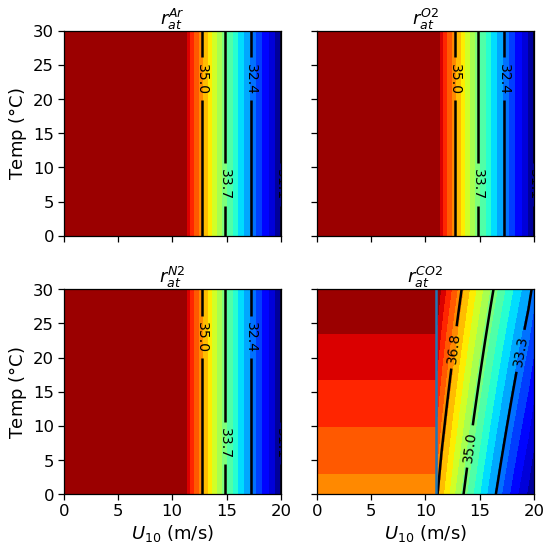

In [58]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            (rwt, rat) = rwtat(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = rat
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$r_{{at}}^{{{gases[i]}}}$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")
    if i==3:
        ax.axvline(11)

plt.tight_layout()

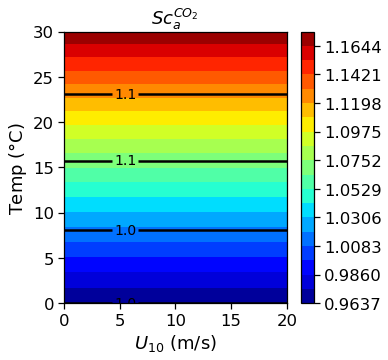

In [144]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        xH2O = xH2O_from_rh(35,y[k],slp=1.0,rh=1.0)
        # Calculate density of air
        rhoa = density(1.0 * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = rhoa = float(rhoa * units('m3/kg')) # need to non-dimensionalize to drop units
        ScA = air_side_Schmidt_number(y[k], rhoa, gas='CO2', calculate=True)
        #(rwt, rat) = rwtat(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
        z[k,j] = ScA
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{CO_2}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7030/631916495.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7030/631916495.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


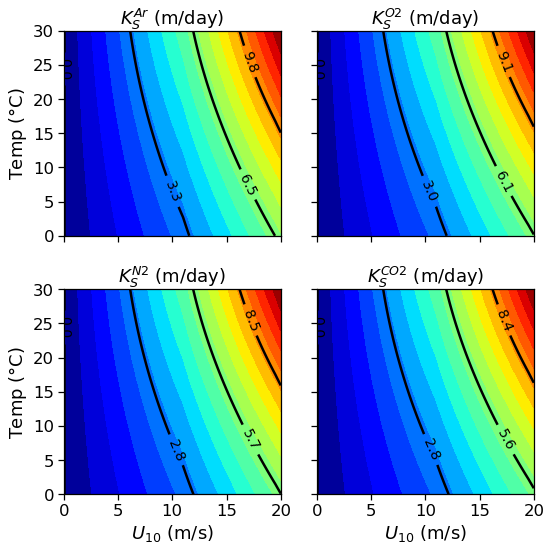

In [134]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = Ks*86400
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$K_S^{{{gases[i]}}}$ (m/day)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_10191/631916495.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_10191/631916495.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


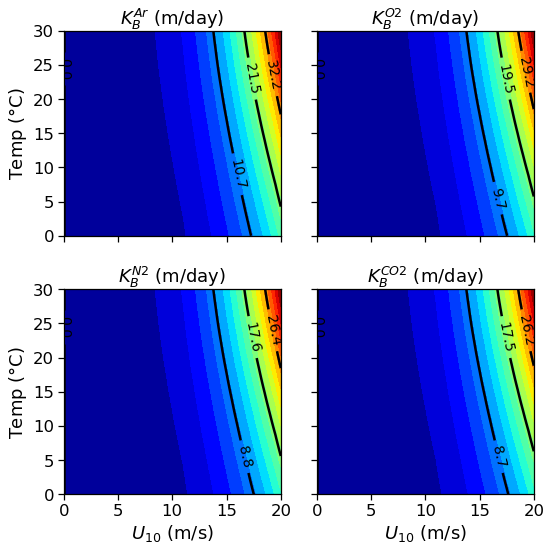

In [64]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = (Kt - Ks)*86400
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$K_B^{{{gases[i]}}}$ (m/day)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/987469457.py:143: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/987469457.py:143: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


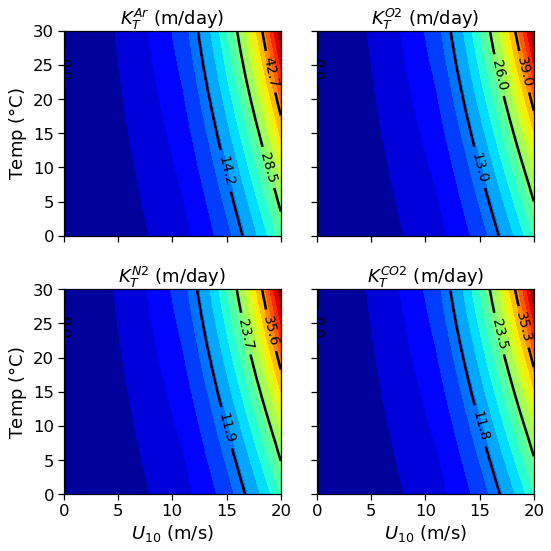

In [124]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = Kt*86400
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$K_T^{{{gases[i]}}}$ (m/day)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/987469457.py:143: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


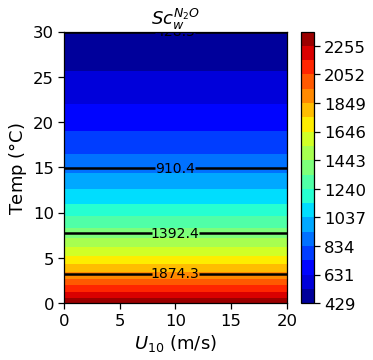

In [102]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        z[k,j] = ScW
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_w^{{N_2O}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/987469457.py:143: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


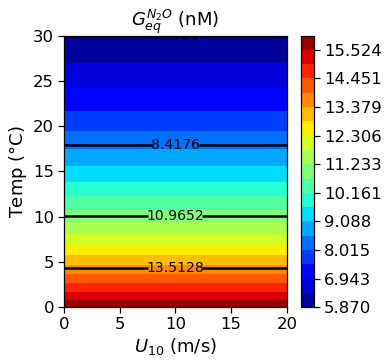

In [113]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        z[k,j] = Geq*1e6
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.4f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$G_{{eq}}^{{N_2O}}$ (nM)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

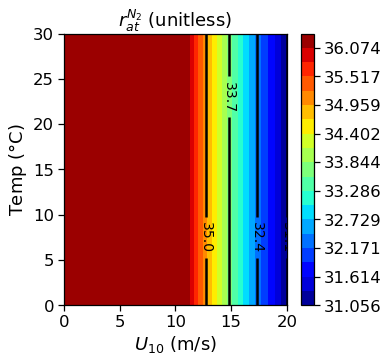

In [60]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rats = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        rwt, rat = rwtat(1e-6,x[j],35,y[k],gas='N2', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        rats[k,j] = rat
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 20)
contourlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rats, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rats, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2}}$ (unitless)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

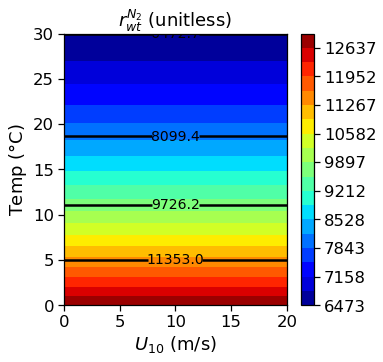

In [61]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rwts = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        rwt, rat = rwtat(1e-6,x[j],35,y[k],gas='N2', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        rwts[k,j] = rwt
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 20)
contourlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rwts, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rwts, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{wt}}^{{N_2}}$ (unitless)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


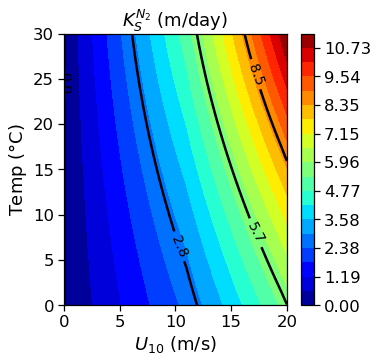

In [62]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        z[k,j] = Ks*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_S^{{N_2}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

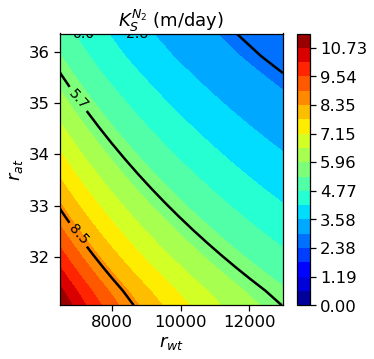

In [63]:
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)

contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(rwts, rats, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(rwts, rats, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$r_{wt}$")
ax.set_ylabel("$r_{at}$")
ax.set_title(fr"$K_S^{{N_2}}$ (m/day)")
cbar = fig.colorbar(cf)

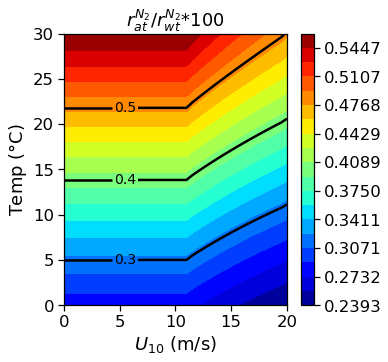

In [197]:
zplot = rats/rwts*100
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 20)
contourlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, zplot, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, zplot, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2}}/r_{{wt}}^{{N_2}}$*100")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

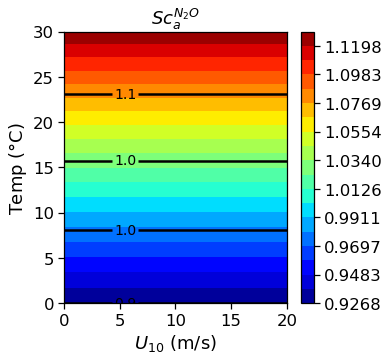

In [149]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        xH2O = xH2O_from_rh(35,y[k],slp=1.0,rh=1.0)
        # Calculate density of air
        rhoa = density(1.0 * units.atm, y[k] * units.degC, xH2O * units('g/kg')) # kg/m3
        rhoa = rhoa = float(rhoa * units('m3/kg')) # need to non-dimensionalize to drop units
        ScA = air_side_Schmidt_number(y[k], rhoa, gas='N2O', calculate=True)
        z[k,j] = ScA
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$Sc_a^{{N_2O}}$")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

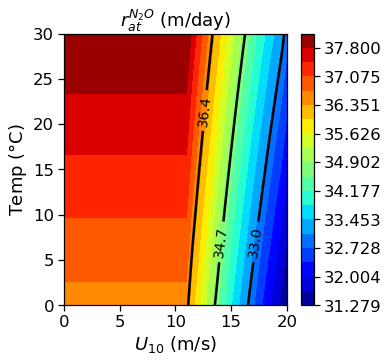

In [64]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rats = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        rwt, rat = rwtat(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        rats[k,j] = rat
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 20)
contourlevs = np.linspace(np.nanmin(rats), np.nanmax(rats), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rats, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rats, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

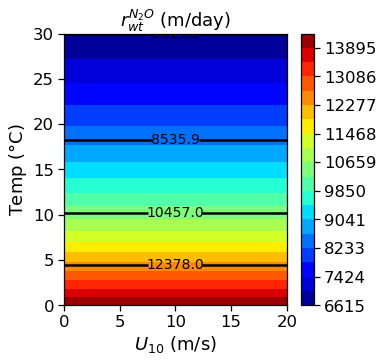

In [65]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

rwts = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        rwt, rat = rwtat(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        rwts[k,j] = rwt
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 20)
contourlevs = np.linspace(np.nanmin(rwts), np.nanmax(rwts), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, rwts, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, rwts, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{wt}}^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


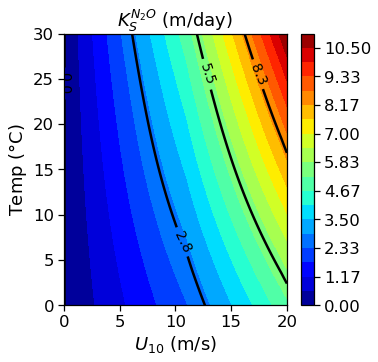

In [66]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        z[k,j] = Ks*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_S^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

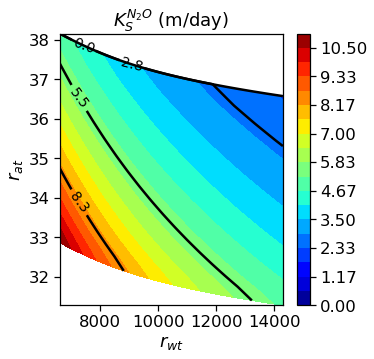

In [67]:
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)

contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(rwts, rats, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(rwts, rats, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$r_{wt}$")
ax.set_ylabel("$r_{at}$")
ax.set_title(fr"$K_S^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)

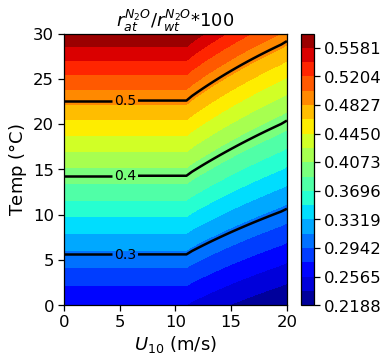

In [187]:
zplot = rats/rwts*100
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 20)
contourlevs = np.linspace(np.nanmin(zplot), np.nanmax(zplot), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, zplot, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, zplot, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$r_{{at}}^{{N_2O}}/r_{{wt}}^{{N_2O}}$*100")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/987469457.py:143: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


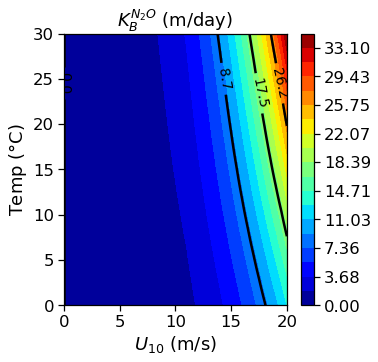

In [123]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        z[k,j] = (Kt - Ks)*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_B^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/987469457.py:143: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


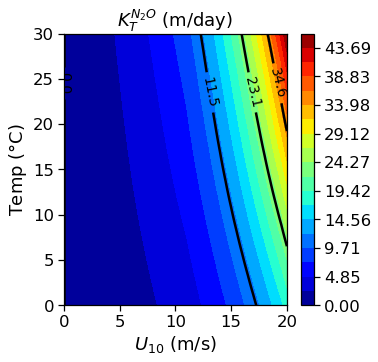

In [128]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True)
        z[k,j] = Kt*86400
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$K_T^{{N_2O}}$ (m/day)")
cbar = fig.colorbar(cf)
#cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/3702119311.py:143: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


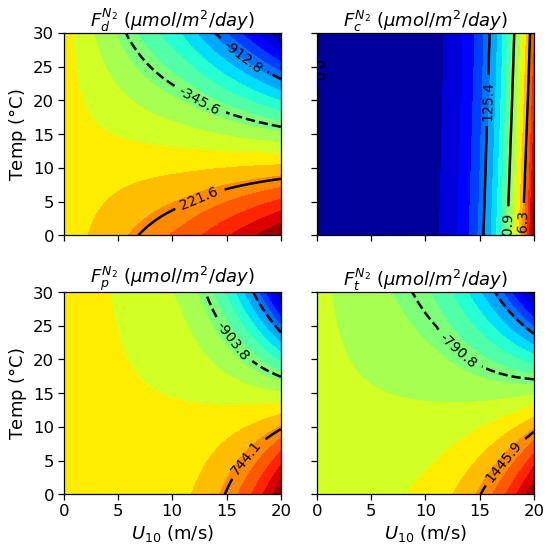

In [217]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(0.5,x[j],35,y[k],gas='N2', chi_atm = None, air_temperature=y[k], calculate_Sca=True)
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{N_2}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_14195/3702119311.py:143: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


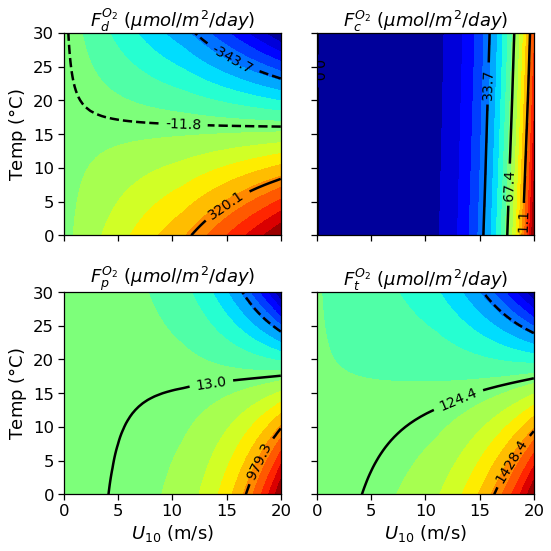

In [221]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(0.25,x[j],35,y[k],gas='O2', chi_atm = None, air_temperature=y[k], calculate_Sca=True)
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{O_2}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

In [220]:
Geq

0.19486252742849972

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_7030/2404852265.py:142: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


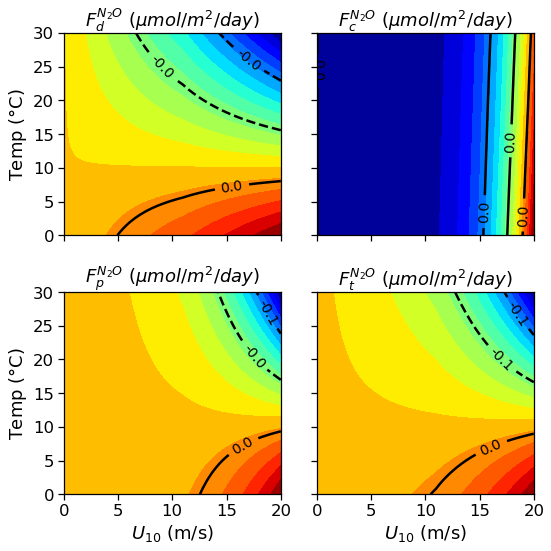

In [200]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)

Fdarray = np.zeros((Ny, Nx))
Fcarray = np.zeros((Ny, Nx))
Fparray = np.zeros((Ny, Nx))
Ftarray = np.zeros((Ny, Nx))

titles =["F_d", "F_c", "F_p", "F_t"]

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(11e-6,x[j],35,y[k],gas='N2O', chi_atm = 338e-9, air_temperature=y[k], calculate_Sca=True)
        Ft = (Fd + Fc + Fp)
        Fdarray[k,j] = Fd*86400*1000
        Fcarray[k,j] = Fc*86400*1000
        Fparray[k,j] = Fp*86400*1000
        Ftarray[k,j] = Ft*86400*1000

arrays = [Fdarray, Fcarray, Fparray, Ftarray]
for i in range(4):
    z = arrays[i]
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(np.nanmin(z), np.nanmax(z), 5)

    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet")#, vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"${titles[i]}^{{N_2O}}\ (\mu mol/m^2/day)$")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

In [201]:
type(Fd)

numpy.float64

In [202]:
Fd

-6.580453915046642e-10

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8031/1554018244.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8031/1554018244.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


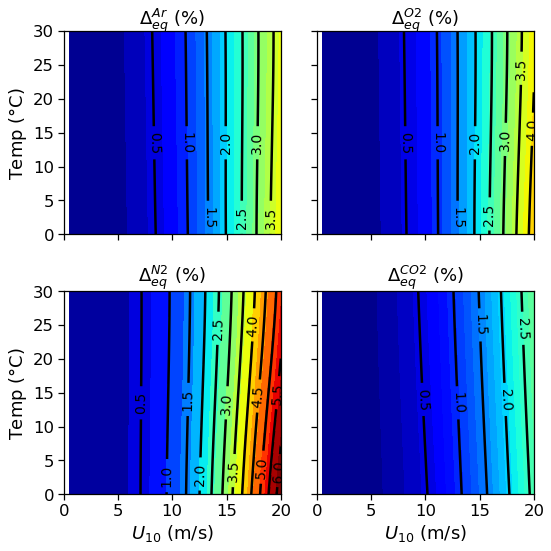

In [149]:
# DON'T CALCULATE AIR_SIDE SCHMIDT
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i])
            z[k,j] = Deq*100
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(0, 6, 13)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$\Delta^{{{gases[i]}}}_{{eq}}$ (%)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


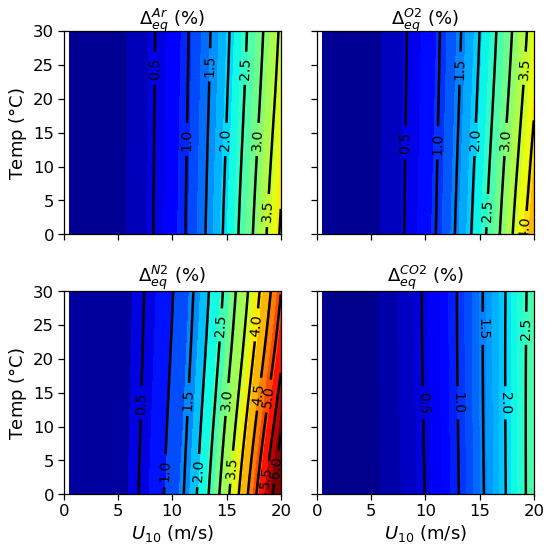

In [76]:
# CALCULATE AIR_SIDE SCHMIDT
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True)
            z[k,j] = Deq*100
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(0, 6, 13)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$\Delta^{{{gases[i]}}}_{{eq}}$ (%)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()
plt.savefig('figures/Deq.png', dpi=300)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in true_divide
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


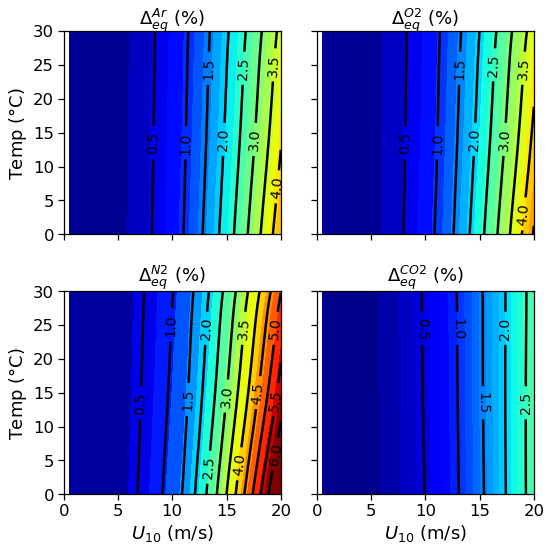

In [74]:
# CALCULATE AIR_SIDE SCHMIDT, CALCULATE WATER-SIDE SCHMIDT WITH W92
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

x_mesh, y_mesh = np.meshgrid(x, y)

gases = ['Ar', 'O2', 'N2', 'CO2']
chivals = [None, None, None, 421e-6]
fig, axes = plt.subplots(2,2, figsize = (8,8), sharex=True, sharey=True)
for i in range(len(gases)):
    
    z = np.zeros((Ny, Nx))
    for j in range(Nx):
        for k in range(Ny):
            Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas=gases[i], chi_atm = chivals[i], air_temperature=y[k], calculate_Sca=True,schmidtcalc="W92")
            z[k,j] = Deq*100
    zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
    contourlevs = np.linspace(0, 6, 13)
    
    ax = axes[i//2, i%2]
    cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6)
    CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
    ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)
    ax.set_title(fr"$\Delta^{{{gases[i]}}}_{{eq}}$ (%)")
    if i // 2 == 1:
        ax.set_xlabel("$U_{10}$ (m/s)")
    if i % 2 == 0:
        ax.set_ylabel("Temp ($\degree$C)")

plt.tight_layout()
plt.savefig('figures/DeqW92.png', dpi=300)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_32883/1554018244.py:140: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


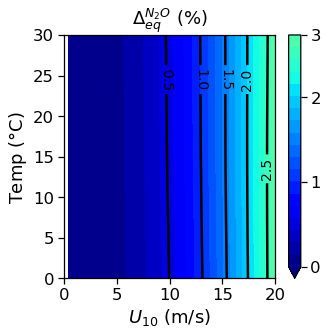

In [75]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=True, schmidtcalc="W92")
        z[k,j] = Deq*100
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(0, 6, 13)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$\Delta^{{N_2O}}_{{eq}}$ (%)")
cbar = fig.colorbar(cf)
cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar
plt.tight_layout()
plt.savefig('figures/N2ODeqW92.png', dpi=300)

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_1211/1377049772.py:144: RuntimeWarning: invalid value encountered in double_scalars
  Deq = (Kb * Geq * dP * slp_corr + Fc) / ((Kb + Ks) * Geq * slp_corr) # percentage


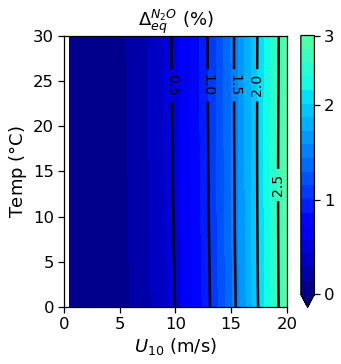

In [66]:
xmin = 0
xmax = 20
dx = 0.5
x = np.arange(xmin, xmax+dx, dx)
Nx = x.size

ymin = 0
ymax = 30
dy = 0.5
y = np.arange(ymin, ymax+dy, dy)
Ny = y.size

z = np.zeros((Ny, Nx))

for j in range(Nx):
    for k in range(Ny):
        Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(1e-6,x[j],35,y[k],gas='N2O', chi_atm=338e-9, air_temperature=y[k], calculate_Sca=False)
        z[k,j] = Deq*100
    
x_mesh, y_mesh = np.meshgrid(x, y)
zlevs = np.linspace(np.nanmin(z), np.nanmax(z), 20)
contourlevs = np.linspace(0, 6, 13)
fig, ax = plt.subplots(1,1, figsize=(5,5))
cf = ax.contourf(x_mesh, y_mesh, z, zlevs, cmap = "jet", vmin=0, vmax = 6, extend='min')
CS = ax.contour(x_mesh, y_mesh, z, contourlevs, colors='k')
ax.clabel(CS, fmt = '%.1f', colors = 'k', fontsize=14)

ax.set_xlabel("$U_{10}$ (m/s)")
ax.set_ylabel("Temp ($\degree$C)")
ax.set_title(fr"$\Delta^{{N_2O}}_{{eq}}$ (%)")
cbar = fig.colorbar(cf)
cbar.ax.set_yticks(np.linspace(0, 3, 4))  # vertically oriented colorbar

In [67]:
L13(200e-6,10,33,30,slp=0.94,gas='N2O',rh=1.0,chi_atm=338e-9, air_temperature=30, calculate_Sca=False)

(-9.89226655389967e-09,
 5.6460695997172704e-14,
 -5.973400091430638e-09,
 0.005067759443385615,
 5.078423570353718e-05,
 8.146081668700936e-05,
 428.5259999999996,
 5.557677389135163e-06)

In [68]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(11e-6,2.5,33,20,slp=1.0,gas='N2O',rh=1.0,chi_atm=338e-9, air_temperature=20, calculate_Sca=True)
F = Fd+Fc+Fp
F.to('umol/(m2 day)')

-2.9156123607580198 <Unit('micromole / day / meter ** 2')>

In [69]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(11e-6,2.5,33,20,slp=1.0,gas='N2O',rh=1.0,chi_atm=None, air_temperature=20, calculate_Sca=True)
F = Fd+Fc+Fp
F.to('umol/(m2 day)')

Magnitude,[-2.9156123607580198]
Units,micromole/(day meter2)


In [70]:
L13(10e-6,10,33,30,slp=0.94,gas='N2O',rh=1.0,chi_atm=None, air_temperature=None, calculate_Sca=False)

(-2.406908862402237e-10,
 7.246503156694889e-14,
 -1.600531441511025e-10,
 0.005808120235159113,
 5.4176036118839464e-05,
 9.084537472408186e-05,
 428.5259999999996,
 5.928212707511454e-06)

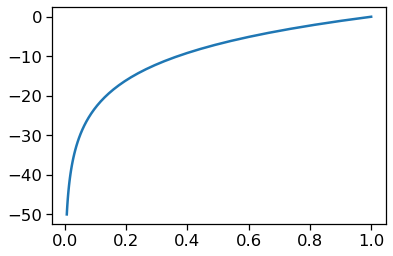

In [71]:
z = np.linspace(-50,0)
z0 = 10
Cb = np.exp(z/z0)

plt.plot(Cb, z)

In [78]:
# functions to compare L13 output with N2O flux from Kelly et al. (2021),
# calculated based on Wanninkhof 2014
def calculate_K0(salt, temp):
    """
    Source: Weiss and Price, 1980 (Table 2).
    Inputs: salinity (PSU); temperature (degrees celsius)
    Ouputs: N2O saturation (nmol/L)
    """
    A1 = -62.7062 # constants from Table 2 in Weiss and Price
    A2 = 97.3066
    A3 = 24.1406
    B1 = -0.05842
    B2 = 0.033193
    B3 = -0.0051313
    tempK = 273.15 + temp # calculate temperature in Kelvins
    lnK0 = A1 + A2*(100/tempK)+A3*np.log(tempK/100)+salt*(B1+B2*(tempK/100)+B3*(tempK/100)**2)
    K0 = np.exp(lnK0) # N2O saturation in mol/L/atm
    return K0

def calculate_schmidt(temp):
    """
    Source: Weiss and Price, 1980 (Table 2).
    Inputs: salinity (PSU); temperature (degrees celsius)
    Ouputs: N2O saturation (nmol/L)
    """
    A = 2356.2 # constants from Table 1 in Wanninkhof, 2014
    B = -166.38
    C = 6.3952
    D = -0.13422
    E = 0.0011506
    Sc = A + B*temp + C*temp**2 + D*temp**3 + E*temp**4 # UNITLESS
    return Sc

def calculate_k(U10, Sc):
    # U10 = windspeed, m/s
    # Sc = temperature-dependent Schmidt number, unitless
    # k = piston velocity, cm/h
    scaling = 0.251 # (cm/h)(m/s)^-2 , Wanninkhof, 2014
    k = scaling * U10**2 * 1/(np.sqrt(Sc/660))
    return k
def calculate_flux(k, k0, dpN2O):
    # k = piston velocity, cm/h
    # k0 = N2O solubility, mol/L/atm
    # dpN2O = ocean-atmosphere pressure gradient, atm
    # k0_transformed = N2O solubility, mol/cm3/atm
    k0_transformed = k0*0.001 # mol/cm3/atm
    F = k * k0_transformed * dpN2O * 10000 # mol/m2/h
    
    
    F1 = F * 8760 # mol N2O/m2/year
    F2 = F1 * 44.013 # g N2O/m2/year
    F3 = F1*10**6/365 # umol N2O/m2/day
    return F2, F3

In [79]:
# read in data from Kelly et al. (2021)
n2o = pd.read_excel('n2otests/surface_N2O.xlsx')
NOAA = pd.read_csv('n2otests/mlo_N2O_MM.dat', delimiter=' ', skiprows=53,header=None)
NOAA = NOAA[[0,7,11]]
NOAA = NOAA.rename(columns = {0:'YYYY', 7:'MM', 11:'XN2Oa'})
ERA5 = xr.open_dataset('n2otests/ERA5_monthly_mean.nc', decode_cf=True)

msl = ERA5['msl'][:]
u10 = ERA5['u10'][:]
v10 = ERA5['v10'][:]

surface_msl = []
surface_U10 = []
surface_XN2Oa = []

for i in list(range(len(n2o))):
    month = n2o['Month'].iloc[i]
    lat = n2o['lat_int'].iloc[i]
    lon = n2o['lon_int'].iloc[i]
    year_int = n2o['Year_int'].iloc[i]
    month_int = n2o['Month_int'].iloc[i]
    msl_i = float(msl.loc[month, lat, lon].values)
    msl_i = msl_i*9.8692e-6 # convert Pa to ATM
    surface_msl.append(msl_i)
    u10_i = float(u10.loc[month, lat, lon].values)
    v10_i = float(v10.loc[month, lat, lon].values)
    U10_i = np.sqrt(u10_i**2 + v10_i**2) # wind speed in m/s
    surface_U10.append(U10_i)
    XN2Oa_i = float(NOAA[(NOAA.YYYY==year_int)&(NOAA.MM==month_int)].XN2Oa)
    surface_XN2Oa.append(XN2Oa_i)
    
n2o['sealevelpressure_atm'] = surface_msl # ATM
n2o['windspeed_m_s'] = surface_U10 # m/s
n2o['K0_mol_L_atm'] = calculate_K0(n2o['Salinity [psu]'],
n2o['Temperature [C]'])
n2o['Sc'] = calculate_schmidt(n2o['Temperature [C]'])
n2o['XN2Oa_ppb'] = surface_XN2Oa
n2o['XN2Ow_ppb'] = n2o.N2O_mean/(n2o.K0_mol_L_atm*n2o.sealevelpressure_atm)
n2o['dXN2O_ppb'] = n2o['XN2Ow_ppb'] - n2o['XN2Oa_ppb']
n2o['dpN2O_atm'] = n2o['dXN2O_ppb']*10**-9*n2o['sealevelpressure_atm']
n2o['k_cm_h'] = calculate_k(n2o['windspeed_m_s'], n2o['Sc'])
n2o['F_g_m2_year'], n2o['F_umol_m2_day'] = calculate_flux(n2o['k_cm_h'],n2o['K0_mol_L_atm'], n2o['dpN2O_atm'] )
n2o['F_umol_m2_day'] = -n2o['F_umol_m2_day']
n2o['F_g_m2_year'] = -n2o['F_g_m2_year']
# add potential temperature for L13 calculation
n2o['pref'] = 0
n2o["SA"] = gsw.SA_from_SP(n2o['Salinity [psu]'],n2o['CTD_Pressure [db]'],n2o['Longitude [E]'],n2o['Latitude [N]'])
n2o['pt'] = gsw.pt_from_t(n2o["SA"],n2o['Temperature [C]'],n2o['CTD_Pressure [db]'], n2o['pref'])

# add concentration in mol/m3 for L13 calculation
n2o["C"] = n2o.N2O_mean*1e-6

# convert XN2O from ppb to mol/mol for L13 calculation
n2o['XN2Oa'] = n2o.XN2Oa_ppb*1e-9

In [82]:
n2ods = n2o.set_index(["Latitude [N]", "Longitude [E]"]).to_xarray()
type(n2ods.C)
n2o[['Cruise','Station','N2O_mean','dXN2O_ppb','windspeed_m_s','Salinity [psu]','pt','F_umol_m2_day']]

,Cruise,Station,N2O_mean,dXN2O_ppb,windspeed_m_s,Salinity [psu],pt,F_umol_m2_day
0,SR1805,PS2,11.061920,244.403181,2.539497,34.1808,27.946305,-2.155207
1,SR1805,PS3,67.495099,2847.817819,1.454974,34.5530,24.231245,-8.320750
2,SR1805,T1,8.559563,119.694796,5.310382,33.6533,28.510086,-4.622334
3,SR1805,T2,10.257601,206.663510,3.953975,33.7303,28.326968,-4.424881
4,SR1805,T3,10.355202,217.993144,2.685918,33.7075,28.766319,-2.152224
5,SR1805,T4,10.892172,225.509236,2.315721,34.4564,27.267452,-1.654242
6,SR1805,T5,11.695256,262.851990,2.847984,34.3444,27.046679,-2.919134
7,SR1805,T6,12.715445,308.481924,2.847984,34.3939,26.677283,-3.428361
8,TN278,BB1,11.453757,215.215418,6.193055,34.6520,24.285235,-11.386204
9,TN278,BB2,5.917854,-28.563552,4.771803,33.8684,26.657477,0.894122


In [81]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(n2ods.C,n2ods.windspeed_m_s,n2ods['Salinity [psu]'],n2ods.pt,
                      slp=n2ods.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2ods['XN2Oa'], air_temperature=n2ods.pt, calculate_Sca=True)
for param in (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq):
    print(type(param))
    
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=n2o.pt, calculate_Sca=True)
for param in (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq):
    print(type(param))

C = np.array(n2o.C)
u10 = np.array(n2o.windspeed_m_s)
S = np.array(n2o['Salinity [psu]'])
pt = np.array(n2o.pt)
P = np.array(n2o.sealevelpressure_atm)
X = np.array(n2o['XN2Oa'])

Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(C,u10,S,pt,
                      slp=P,gas='N2O',rh=1.0,chi_atm=X, air_temperature=pt, calculate_Sca=True)
for param in (Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq):
    print(type(param))

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [57]:
C = np.array(n2o.C)
u10 = np.array(n2o.windspeed_m_s)
S = np.array(n2o['Salinity [psu]'])
pt = np.array(n2o.pt)
P = np.array(n2o.sealevelpressure_atm)
X = np.array(n2o['XN2Oa'])

In [156]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=n2o.pt, calculate_Sca=True)

In [157]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=n2o.pt, calculate_Sca=True)
F1 = Fd+Fc+Fp
F1.to('umol/(m2 day)')

Magnitude,[-5.760410050968101 -36.054144429196064 -7.1161243124697116 -8.151323589919782 -5.506320187670585 -4.829745758529283 -7.014010277717321 -8.182020778403684 -15.006249134790508 0.7759462177783447]
Units,micromole/(day meter2)


In [158]:
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(n2o.C,n2o.windspeed_m_s,n2o['Salinity [psu]'],n2o.pt,
                      slp=n2o.sealevelpressure_atm,gas='N2O',rh=1.0,chi_atm=n2o['XN2Oa'], air_temperature=None, calculate_Sca=False)
F2 = Fd+Fc+Fp
F2.to('umol/(m2 day)')

Magnitude,[-5.949810941719159 -36.879524635225 -7.406265138060122 -8.451669511055824 -5.69946091152202 -4.978275010169057 -7.23351043468335 -8.43089513724239 -15.462311582932935 0.8033327018925918]
Units,micromole/(day meter2)


In [159]:
n2o['F_bubbles_Sca'] = F1.to('umol/(m2 day)')
n2o['F_bubbles_only'] = F2.to('umol/(m2 day)')

In [160]:
n2o[['Cruise','Station','N2O_mean','dXN2O_ppb','windspeed_m_s','F_umol_m2_day','F_bubbles_Sca','F_bubbles_only']]

,Cruise,Station,N2O_mean,dXN2O_ppb,windspeed_m_s,F_umol_m2_day,F_bubbles_Sca,F_bubbles_only
0,SR1805,PS2,11.061920,244.403181,2.539497,-2.155207,-5.760410,-5.949811
1,SR1805,PS3,67.495099,2847.817819,1.454974,-8.320750,-36.054144,-36.879525
2,SR1805,T1,8.559563,119.694796,5.310382,-4.622334,-7.116124,-7.406265
3,SR1805,T2,10.257601,206.663510,3.953975,-4.424881,-8.151324,-8.451670
4,SR1805,T3,10.355202,217.993144,2.685918,-2.152224,-5.506320,-5.699461
5,SR1805,T4,10.892172,225.509236,2.315721,-1.654242,-4.829746,-4.978275
6,SR1805,T5,11.695256,262.851990,2.847984,-2.919134,-7.014010,-7.233510
7,SR1805,T6,12.715445,308.481924,2.847984,-3.428361,-8.182021,-8.430895
8,TN278,BB1,11.453757,215.215418,6.193055,-11.386204,-15.006249,-15.462312
9,TN278,BB2,5.917854,-28.563552,4.771803,0.894122,0.775946,0.803333


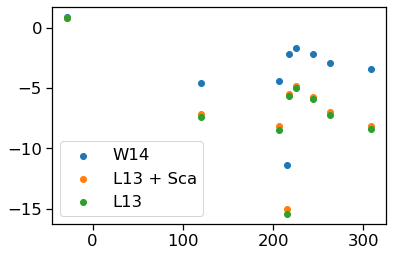

In [161]:
plotdf = n2o[n2o.dXN2O_ppb < 1000]
fig, ax = plt.subplots()
ax.scatter(plotdf.dXN2O_ppb, plotdf.F_umol_m2_day, label = "W14")
ax.scatter(plotdf.dXN2O_ppb, plotdf.F_bubbles_Sca, label = "L13 + Sca")
ax.scatter(plotdf.dXN2O_ppb, plotdf.F_bubbles_only, label = "L13")
ax.legend()

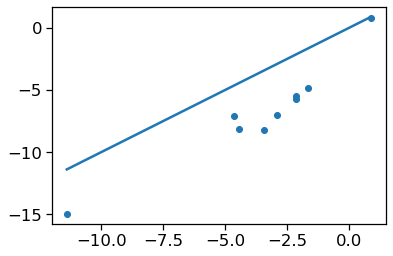

In [162]:
fig, ax = plt.subplots()
ax.scatter(plotdf.F_umol_m2_day, plotdf.F_bubbles_Sca)
ax.plot(np.linspace(plotdf.F_umol_m2_day.min(), plotdf.F_umol_m2_day.max()),
       np.linspace(plotdf.F_umol_m2_day.min(), plotdf.F_umol_m2_day.max()))

In [163]:
# read in S04P data
s04 = pd.read_csv('n2otests/s04.csv')
# set up datetime column in S04P data to match with atmospheric N2O - eventually want to put this in compiledata.py?
s04["date"] = s04.DATE.astype('int').astype('str')
s04["hour"] = s04.TIME // 100
s04["hour"] = s04["hour"].astype('int').astype('str').str.zfill(2)
s04["minute"] = s04.TIME % 100
s04["minute"] = s04["minute"].astype('int').astype('str').str.zfill(2)
s04['datetime'] = s04["date"] + " " + s04["hour"] + ":" + s04["minute"]
s04['t'] = pd.to_datetime(s04['datetime'], format='%Y%m%d %H:%M')
# create timedelta variable, referenced to earliest Argo sample time
s04['timedelta'] = (s04['t'] - s04['t'].min())  / np.timedelta64(1,'D')# convert timestamps to floats for interpolation


# zonal mean atmospheric N2O
zonal = pd.read_csv(f"n2otests/n2o_mm_zonal_updated.csv",
                   parse_dates = ["t"]) # parse dates to attach to S04 data
# want atmospheric N2O data from southernmost bin
band = [-90,-45]
# select data from southernmost bin
atmsubset = pd.DataFrame(zonal[['year', 'month', 'day', 't', f"bin{band[0]}-{band[1]}"]]).rename(columns = {
            f"bin{band[0]}-{band[1]}":'n2o_atm'})
# create numeric timedelta for interpolation, referenced to earliest Argo sample time
atmsubset['timedelta'] = (atmsubset.t - s04['t'].min())  / np.timedelta64(1,'D')
# select atmospheric data from time period of argo data
atmsubset = atmsubset[atmsubset.timedelta>-30] # choose 30 so we can interpolate through 0

# interpolation
x = np.array(atmsubset.timedelta)
y = np.array(atmsubset.n2o_atm)
s04['n2o_atm'] = s04['N2Osol'] # create another variable with the same coords and N2Osol
# np.interp: 1D linear interpolation for monotonically increasing sample points
s04['n2o_atm'] = np.interp(s04['timedelta'][:].values, x, y)
s04['n2o_atm']

0       329.483355
1       329.483355
2       329.483355
3       329.483355
4       329.483355
           ...    
4069    329.486096
4070    329.486096
4071    329.486096
4072    329.486096
4073    329.486096
Name: n2o_atm, Length: 4074, dtype: float64

In [75]:
s04.columns

Index(['Unnamed: 0', 'LONGITUDE', 'LATITUDE', 'YEAR', 'EXPOCODE', 'woce_lines',
       'startDate', 'endDate', 'source', 'SECT_ID', 'STNNBR', 'CASTNO',
       'BTLNBR', 'SAMPNO', 'DATE', 'TIME', 'DEPTH', 'CTDPRS', 'CTDPRS_FLAG_W',
       'CTDTMP', 'CTDTMP_FLAG_W', 'CTDSAL', 'CTDSAL_FLAG_W', 'SALNTY',
       'SALNTY_FLAG_W', 'CTDOXY', 'CTDOXY_FLAG_W', 'NITRAT', 'NITRAT_FLAG_W',
       'N2O', 'N2O_FLAG_W', 'SA', 'PT', 'CT', 'rho', 'sigma0', 'O2sat',
       'spiciness', 'AOU', 'N2O_nM', 'N2Osol', 'pN2O', 'DN2O', 'BIOME_NUM',
       'BIOME_ABREV', 'BIOME_FULL', 'date', 'hour', 'minute', 'datetime', 't',
       'timedelta', 'n2o_atm'],
      dtype='object')

In [76]:
# figure out what years of ERA5 data we need
print(s04.t.min(), s04.t.max())

2018-01-11 08:16:00 2018-05-09 01:51:00


In [77]:
# read in ERA5 sea level pressure data
fname = "n2otests/2018_mean_sea_level_pressure.nc"
era = xr.open_dataset(fname)
era

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 241, time: 1460)
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -30.0 -30.25 -30.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Data variables:
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-03 21:33:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [78]:
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [79]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [80]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
msl_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5

    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    msl = eratemp['msl'][:].values/101325.0 # convert Pa to Atm
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), msl, method="nearest")
    
    msl_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [81]:
# read in ERA5 u-component wind speed data
fname = "n2otests/2018_10m_u_component_of_wind.nc"
era = xr.open_dataset(fname)
era.u10.values

array([[[ 1.2339842e+00,  1.1582596e+00,  1.0221601e+00, ...,
          9.7201800e-01,  1.0231833e+00,  1.1275606e+00],
        [ 1.5880480e+00,  1.5419993e+00,  1.3987365e+00, ...,
          1.3445013e+00,  1.3946433e+00,  1.5113001e+00],
        [ 1.8530846e+00,  1.8408046e+00,  1.7087984e+00, ...,
          1.6494465e+00,  1.6719594e+00,  1.7794065e+00],
        ...,
        [ 6.8344569e-01,  6.6604948e-01,  6.4660668e-01, ...,
          7.3665762e-01,  7.1926141e-01,  7.0186520e-01],
        [ 8.4512806e-01,  8.3694172e-01,  8.2773185e-01, ...,
          8.7275743e-01,  8.6354756e-01,  8.5536122e-01],
        [ 6.6297960e-01,  6.6297960e-01,  6.6297960e-01, ...,
          6.6297960e-01,  6.6297960e-01,  6.6297960e-01]],

       [[-7.0730686e-02, -2.0990014e-01, -3.2962704e-01, ...,
          7.5602055e-02,  4.4903040e-02, -7.2855949e-03],
        [ 3.1198573e-01,  1.5337348e-01,  2.4436951e-02, ...,
          3.1403232e-01,  3.7645411e-01,  3.7440753e-01],
        [ 5.7088208e-01, 

In [82]:
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [83]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [84]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
u10_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    u10 = eratemp['u10'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), u10, method="nearest")
    
    u10_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [85]:
u10_interpolated

array([  3.89150953,   1.54609251,   4.03170252,   6.62066603,
         7.44545031,   9.52480888,   6.40065527,  10.74254227,
         1.53585958,   4.54949522,   9.47057343,  -0.1014297 ,
        -1.34065306,   8.74504852,  10.54197311,   8.97836304,
         7.36051607,   5.7754159 ,  -6.57997894,   4.93118811,
        11.00450897,  11.40666771,  -8.68082619, -12.42612457,
        -2.51336145,  -6.39066696,   7.80053759,   6.04863787,
        -8.9346056 , -10.77246284,   6.89593554,   4.08696079,
         8.18018341,  -7.37304068,  -7.09572506,  11.39950371,
        -6.18395948,  -3.39238119,   8.16278839,  -1.44298363,
         2.72903395,   5.54824162,   6.61759615,   5.5748477 ,
        11.22042656,   9.84510231,   4.68764162,   4.56177473,
         5.73755312,   4.5525651 ,  -3.72700214,  -5.33256912,
        -5.96190214,  -3.53973722,  -1.2946043 ,  -0.71336663,
         2.6707058 ,   5.08980083,   8.91901016,   8.92412758,
         7.36256266,   6.59099054,   6.9624505 ,  10.41

In [86]:
# read in ERA5 v-component wind speed data
fname = "n2otests/2018_10m_v_component_of_wind.nc"
era = xr.open_dataset(fname)
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

era.latitude.max()

<xarray.DataArray 'latitude' ()>
array(-30.)

In [87]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [88]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
v10_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    v10 = eratemp['v10'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), v10, method="nearest")
    
    v10_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [89]:
v10_interpolated

array([  5.32538271,   4.1496172 ,   4.50214815,   3.39291644,
         5.02746916,   3.22509193,   8.53093243,   2.55677223,
         6.25090075,   4.54187012,   7.28068876,   3.9688828 ,
         8.2816782 ,   1.50116515,  -1.20389009,   6.39092016,
        -2.24758077,  -3.77091241,  -3.96852803,   9.17442608,
        -0.21779609,   4.77225637,  -1.37469411,   2.21417189,
        -6.53257179, -10.23563671,   2.76332569,   2.15558195,
        -1.37866616,   3.62230992,   3.81198168, -11.1899538 ,
         1.28666735,  -5.16117573,  -4.2723999 ,   4.26878262,
        -0.78581786,  -1.2426188 ,   4.84574175,   0.92519903,
         3.44753408,   5.30452871,   7.01256657,   5.45944357,
         3.45051312,   3.35915279,  -4.08272839,  -5.44617939,
        -2.74410319,  -2.25353885,  -3.60805297,  -1.89802861,
         4.3293581 ,   2.38696146,  -5.01917076,  -9.4024725 ,
        -4.82453346,   5.09499598,   1.82291198,  -1.10061336,
        -6.1949358 ,  -6.40943336, -10.53057194,  -6.89

In [90]:
# read in ERA5 2m air temperature
fname = "n2otests/2018_2m_temperature.nc"
era = xr.open_dataset(fname)
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [91]:
era.t2m

<xarray.DataArray 't2m' (time: 1460, latitude: 181, longitude: 1440)>
[380534400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -45.0 -45.25 -45.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature

In [92]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [93]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
t2m_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    t2m = eratemp['t2m'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), t2m, method="nearest")
    
    t2m_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

t2m_interpolated = t2m_interpolated - 273.15

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [94]:
t2m_interpolated

array([-3.38257446e+00, -2.66388550e+00, -2.37750854e+00, -3.03494873e+00,
       -2.97009888e+00, -2.88904419e+00, -4.19129028e+00, -2.72333374e+00,
       -3.68695679e+00, -4.06522217e+00, -1.96683350e+00, -3.48883667e+00,
       -5.67908325e+00, -3.26367798e+00, -2.11453857e+00, -5.24860229e+00,
       -1.27698364e+00, -1.48770752e+00, -2.52161255e+00, -2.46936646e+00,
       -2.02808228e+00, -5.02524414e+00, -1.06935791e+01, -5.54398193e+00,
       -1.13468018e+00, -1.00501099e+00, -2.17938843e+00, -1.87677612e+00,
       -2.11813965e+00, -7.50369873e+00, -2.06049194e+00, -1.15088501e+00,
       -2.34146729e+00, -9.99609375e-01, -1.57596436e+00, -3.88870850e+00,
       -1.08196777e+01, -1.17400879e+01, -1.11487427e+00, -1.21525635e+01,
       -1.20048584e+01, -1.15041260e+01, -1.14356750e+01, -1.14158691e+01,
       -3.92584229e-01, -5.42089844e-01, -1.43729248e+00, -9.68969727e-01,
       -1.01401367e+00, -1.43009033e+00, -1.43729248e+00, -1.48770752e+00,
       -2.07669678e+00, -

In [95]:
# read in ERA5 dewpoint temperature
fname = "n2otests/2018_2m_dewpoint_temperature.nc"
era = xr.open_dataset(fname)
# create new timedelta variable for comparison to ERA5 data
# referenced to earliest ERA5 time
s04['timedeltaERA'] = (s04['t'] - era['time'][:].values.min()) / np.timedelta64(1,'D')
s04['timedeltaERA'].min()

10.344444444444445

In [96]:
era.d2m

<xarray.DataArray 'd2m' (time: 1460, latitude: 181, longitude: 1440)>
[380534400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * latitude   (latitude) float32 -45.0 -45.25 -45.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T18:00:00
Attributes:
    units:      K
    long_name:  2 metre dewpoint temperature

In [97]:
# create surface variables that only have values where:
# pressure < 10 db
# latitude is within range covered by ERA5 data
surface = s04[(s04.CTDPRS<10) &
            (s04['LATITUDE']<=-45)]

surfacelon = np.array(surface.LONGITUDE)
surfacelat = np.array(surface.LATITUDE)
surfacetime = np.array(surface.timedeltaERA)
n2o_atm_ppb = np.array(surface['n2o_atm'])
pN2O = np.array(surface['pN2O'])

pN2O.shape

(119,)

In [98]:
# calculate total number of interpolations
total_interpolations = len(surfacetime)

# create a progress bar
progress_bar = tqdm(total=total_interpolations, desc='Interpolating')

# initialize interpolated values array
d2m_interpolated = np.zeros(total_interpolations)

# calculate and apply interpolation
for i in range(total_interpolations):

    lon = surfacelon[i]
    lat = surfacelat[i]
    time = surfacetime[i]

    # narrow down era5 data to lats and lons covered by this argo float
    # need to do this to reduce memory usage/time for merging and interpolation
    lonmin2 = np.round(lon*4)/4 - 0.5 # rounded min. might be slightly higher than actual min, so subtract 0.25
    lonmax2 = np.round(lon*4)/4 + 0.5
    latmin2 = np.round(lat*4)/4 + 0.5 # the era index goes from less negative to more negative
    latmax2 = np.round(lat*4)/4 - 0.5
    
    eratemp = era.sel(longitude=slice(lonmin2,lonmax2),
       latitude = slice(latmin2,latmax2))

    # create meshgrid of ERA5 time, lat, and lon
    d2m = eratemp['d2m'][:].values
    x = eratemp['time'][:].values
    # convert timestamps to floats for interpolation
    # referenced to the same starting point as 'timedeltaERA'
    x = (x - eratemp['time'][:].values.min())  / np.timedelta64(1,'D')
    y = eratemp['latitude'][:].values
    z = eratemp['longitude'][:].values
    xg, yg, zg = np.meshgrid(x, y, z, indexing='ij', sparse=True)

    # interpolate over ERA5 grid
    # calculate interpolation function
    interp = RegularGridInterpolator((x, y, z), d2m, method="nearest")
    
    d2m_interpolated[i] = interp(np.array((time, lat, lon)).T)
    
    progress_bar.update(1)

# close the progress bar
progress_bar.close()

d2m_interpolated = d2m_interpolated - 273.15

Interpolating:   0%|          | 0/119 [00:00<?, ?it/s]

In [99]:
d2m_interpolated

array([-1.12461304e+01, -1.09034180e+01, -9.49121704e+00, -9.24417725e+00,
       -7.91641846e+00, -7.51636353e+00, -1.05607361e+01, -6.11371460e+00,
       -7.83194580e+00, -9.67612305e+00, -7.82556763e+00, -6.01965942e+00,
       -1.01606812e+01, -9.42746582e+00, -9.14694824e+00, -9.58685913e+00,
       -2.74893799e+00, -4.00494995e+00, -4.96927490e+00, -4.98682251e+00,
       -4.71903076e+00, -1.01750244e+01, -1.24527344e+01, -7.05411377e+00,
       -1.73840942e+00, -2.14325562e+00, -5.88419189e+00, -4.19144287e+00,
       -2.92270508e+00, -9.05768433e+00, -4.68717041e+00, -2.37598267e+00,
       -7.33466187e+00, -1.79419556e+00, -2.32495728e+00, -8.78671875e+00,
       -1.30902771e+01, -1.39637512e+01, -2.16718140e+00, -1.43160156e+01,
       -1.42681946e+01, -1.37023376e+01, -1.38155273e+01, -1.37501587e+01,
       -1.46427002e+00, -1.78940430e+00, -2.54013672e+00, -1.60770264e+00,
       -1.69855347e+00, -2.31381836e+00, -2.62781372e+00, -2.76968994e+00,
       -3.62720337e+00, -

In [100]:
sp = np.array(surface.CTDSAL)
pt = np.array(surface.PT)
pN2O = np.array(surface.pN2O)
n2o_atm = np.array(surface.n2o_atm)
U10 = np.sqrt(u10_interpolated**2 + v10_interpolated**2)
rh = rh_from_dewpoint_t2m(t2m_interpolated, d2m_interpolated)
C = np.array(surface.N2O_nM*1e-6)
# convert XN2O from ppb to mol/mol for L13 calculation
XN2Oa = np.array(surface.n2o_atm*1e-9)

surf = np.array((surfacelat, surfacelon, sp, pt, C, XN2Oa,
                 msl_interpolated, u10_interpolated, v10_interpolated, U10, t2m_interpolated, d2m_interpolated, rh)).T
fluxdf = pd.DataFrame(surf, columns = ["LATITUDE", "LONGITUDE", "SP", "pt", "N2O", "xN2O_atm",
                              "msl", "u10", "v10", "U10", "t2m", "d2m", "rh"])
fluxdf.head()

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599


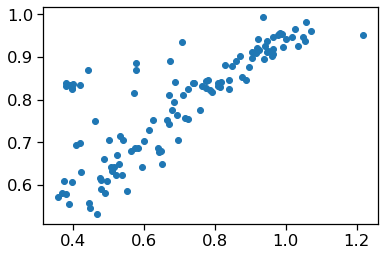

In [101]:
rh1 = rh_from_dewpoint_SP_pt(sp, pt, d2m_interpolated)
rh2 = rh_from_dewpoint_t2m(t2m_interpolated, d2m_interpolated)
plt.scatter(rh1, rh2)

In [113]:
# L13 flux with 2m relative humidity & temp.
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(fluxdf.N2O,fluxdf.U10,fluxdf.SP,fluxdf.pt,slp=fluxdf.msl,
                                          gas='N2O',rh=fluxdf.rh,chi_atm=fluxdf.xN2O_atm,
                                          air_temperature=fluxdf.t2m, calculate_Sca=True)
Ft1 = Fd+Fc+Fp
Ft1 = Ft1.to('umol/(m2 day)')
fluxdf["Ft1"] = Ft1
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft,F_umol_m2_day,Ft1
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-1.918163,-1.516863,-1.918163
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.269349,-0.743393,-1.269349
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.879976,-1.407631,-1.879976
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.634025,-2.238207,-2.634025
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.188205,-0.151908,-0.188205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.137505,-2.071510,-2.137505
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.238100,-1.006272,-1.238100
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.342885,0.419452,0.342885
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.537208,-0.252367,-0.537208


In [114]:
# L13 flux, assume RH=1 and air temp=surface temp
Fd,Fc,Fp,Deq,Ks,Kt,ScW,Geq = L13unitcheck(fluxdf.N2O,fluxdf.U10,fluxdf.SP,fluxdf.pt,slp=fluxdf.msl,
                                          gas='N2O',rh=1.0,chi_atm=fluxdf.xN2O_atm,
                                          air_temperature=fluxdf.pt, calculate_Sca=True)
Ft = Fd+Fc+Fp
Ft = Ft.to('umol/(m2 day)')
fluxdf["Ft"] = Ft
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft,F_umol_m2_day,Ft1
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-2.043735,-1.516863,-1.918163
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.349183,-0.743393,-1.269349
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.988101,-1.407631,-1.879976
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.754001,-2.238207,-2.634025
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.337362,-0.151908,-0.188205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.400112,-2.071510,-2.137505
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.404020,-1.006272,-1.238100
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.288775,0.419452,0.342885
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.656769,-0.252367,-0.537208


In [119]:
K0_mol_L_atm = calculate_K0(sp,pt)
Sc = calculate_schmidt(pt)
pN2O_atm = pN2Oatm(sp,pt,slp=msl_interpolated,xn2o=XN2Oa, units = "natm", v=32.3, watervapor=True, nonideal=True)
dpN2O = (pN2O_atm - pN2O)*1e-9
k_cm_h = calculate_k(U10, Sc)
F_g_m2_year, F_umol_m2_day = calculate_flux(k_cm_h,K0_mol_L_atm, dpN2O)
fluxdf["F_umol_m2_day"] = F_umol_m2_day
fluxdf

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft,F_umol_m2_day,Ft1
0,-67.0002,-179.2944,34.0755,-0.723987,0.000017,3.294834e-07,0.991965,3.891510,5.325383,6.595722,-3.382574,-11.246130,0.544812,-2.043735,-1.516863,-1.918163
1,-67.0003,-178.0182,33.9971,-0.956819,0.000017,3.294805e-07,0.992346,1.546093,4.149617,4.428287,-2.663885,-10.903418,0.530713,-1.349183,-0.743393,-1.269349
2,-67.0014,-176.7294,33.9856,-0.003807,0.000017,3.294773e-07,0.992614,4.031703,4.502148,6.043506,-2.377509,-9.491217,0.580974,-1.988101,-1.407631,-1.879976
3,-67.0008,-175.4651,34.0520,-0.603686,0.000017,3.294743e-07,0.991690,6.620666,3.392916,7.439429,-3.034949,-9.244177,0.622012,-2.754001,-2.238207,-2.634025
4,-66.9999,-173.8192,34.0801,-0.733024,0.000016,3.294659e-07,0.991882,7.445450,5.027469,8.983884,-2.970099,-7.916418,0.686599,-0.337362,-0.151908,-0.188205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-67.6155,173.5408,34.0405,-0.741753,0.000016,3.295004e-07,0.986837,12.196659,-0.408461,12.203497,-1.431891,-6.638098,0.676284,-2.400112,-2.071510,-2.137505
115,-67.2488,174.4687,34.0408,-0.935808,0.000017,3.294974e-07,0.987382,8.952780,-1.690482,9.110982,-0.943762,-6.701880,0.649304,-1.404020,-1.006272,-1.238100
116,-66.9985,176.8609,34.0227,-0.970711,0.000016,3.294918e-07,0.983479,1.718008,5.024490,5.310089,-2.267645,-5.865057,0.763129,0.288775,0.419452,0.342885
117,-66.9992,178.1452,34.0348,-0.562308,0.000016,3.294889e-07,0.985356,2.677869,6.180395,6.735596,-3.350134,-9.827551,0.608244,-0.656769,-0.252367,-0.537208


(array([ 1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  1.,  1.,  2.,  1.,  3.,  2.,  1.,  0.,  4.,  1.,  1.,
         2.,  5.,  6.,  6.,  6., 11., 11., 12., 15., 15.,  2.,  3.,  1.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  2.,  0.,  1.]),
 array([-0.44104949, -0.4291629 , -0.41727631, -0.40538971, -0.39350312,
        -0.38161653, -0.36972993, -0.35784334, -0.34595675, -0.33407015,
        -0.32218356, -0.31029697, -0.29841037, -0.28652378, -0.27463719,
        -0.26275059, -0.250864  , -0.23897741, -0.22709081, -0.21520422,
        -0.20331763, -0.19143103, -0.17954444, -0.16765785, -0.15577125,
        -0.14388466, -0.13199807, -0.12011147, -0.10822488, -0.09633829,
        -0.08445169, -0.0725651 , -0.06067851, -0.04879191, -0.03690532,
        -0.02501873, -0.01313213, -0.00124554,  0.01064105,  0.02252764,
         0.03441424,  0.04630083,  0.05818742,  0.07007402,  0.08196061,
         0.0938472 ,  0.1057338 ,  0.11762039,  0.12950698,

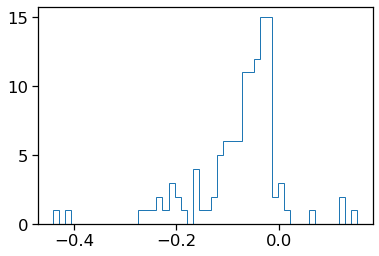

In [122]:
plt.hist(fluxdf.Ft - fluxdf.Ft1, bins = 50, histtype = "step")

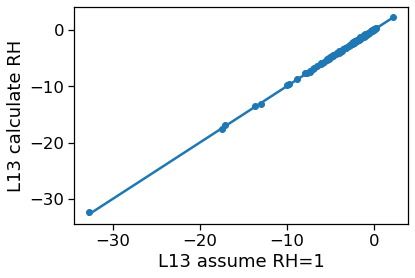

In [117]:
fig, ax = plt.subplots()
ax.scatter(fluxdf.Ft, fluxdf.Ft1)
ax.set_xlabel("L13 assume RH=1")
ax.set_ylabel("L13 calculate RH")
ax.plot(np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()),
        np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()))

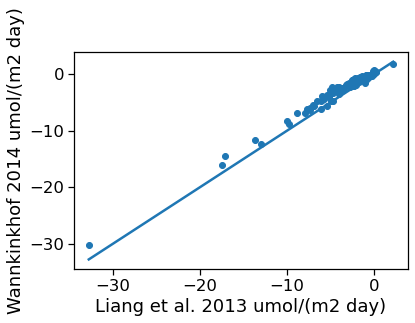

In [118]:
fig, ax = plt.subplots()
ax.scatter(fluxdf.Ft, fluxdf.F_umol_m2_day)
ax.set_ylabel("Wannkinkhof 2014 umol/(m2 day)")
ax.set_xlabel("Liang et al. 2013 umol/(m2 day)")
ax.plot(np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()),
        np.linspace(fluxdf.Ft.min(), fluxdf.Ft.max()))

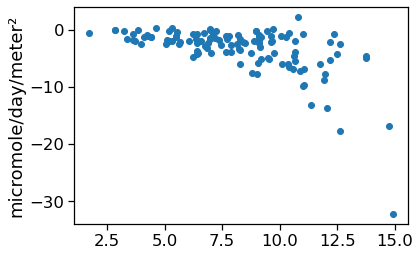

In [108]:
plt.scatter(U10, Ft)

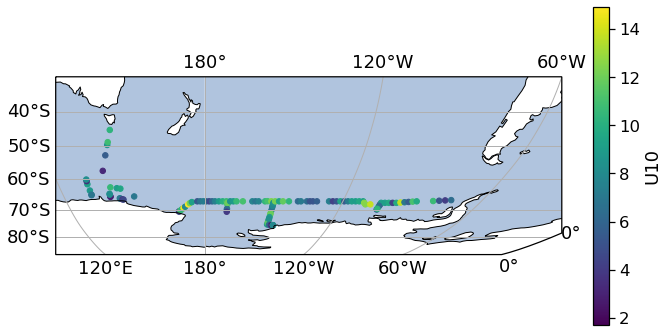

In [109]:
plotdf = fluxdf
fig = plt.figure(figsize=[10, 5]) #figsize=fig dimension (width, height) in inches
#fig = plt.figure(figsize=[20, 10]) #figsize=fig dimension (width, height) in inches
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180.0))

cax=ax.scatter(x=plotdf.LONGITUDE,y=plotdf.LATITUDE,
               c = U10,
               #edgecolor = colors[count,:3],
               s=30,
           #label = w,
               #norm=pltcolors.PowerNorm(gamma=2),
        transform=ccrs.PlateCarree(),
              cmap = "viridis"
              )

cbar = fig.colorbar(cax).set_label(r'U10')
#cax.set_clim([-75,300])
    
ax.set_extent([-230, -60, -90, -30], ccrs.PlateCarree()) #can adjust these lat/long to change range of map
ax.gridlines(draw_labels=True)
ax.coastlines(color='black',facecolor='gray')
ax.add_feature(cfeature.OCEAN,facecolor='lightsteelblue')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.set_facecolor("k")
plt.tight_layout()
plt.show()

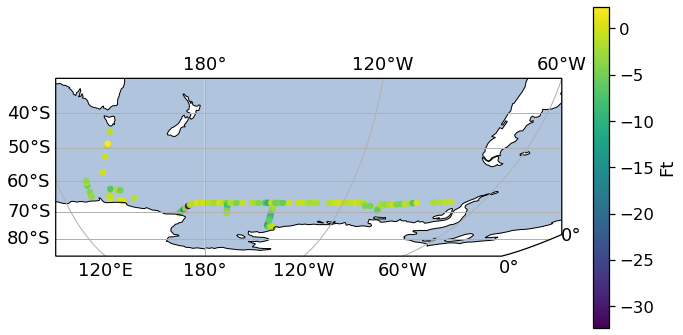

In [110]:
plotdf = fluxdf
fig = plt.figure(figsize=[10, 5]) #figsize=fig dimension (width, height) in inches
#fig = plt.figure(figsize=[20, 10]) #figsize=fig dimension (width, height) in inches
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180.0))

cax=ax.scatter(x=plotdf.LONGITUDE,y=plotdf.LATITUDE,
               c = plotdf["Ft"],
               #edgecolor = colors[count,:3],
               s=30,
           #label = w,
               #norm=pltcolors.PowerNorm(gamma=2),
        transform=ccrs.PlateCarree(),
              cmap = "viridis"
              )

cbar = fig.colorbar(cax).set_label(r'Ft')
#cax.set_clim([-75,300])
    
ax.set_extent([-230, -60, -90, -30], ccrs.PlateCarree()) #can adjust these lat/long to change range of map
ax.gridlines(draw_labels=True)
ax.coastlines(color='black',facecolor='gray')
ax.add_feature(cfeature.OCEAN,facecolor='lightsteelblue')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.set_facecolor("k")
plt.tight_layout()
plt.show()

In [111]:
fluxdf[fluxdf.Ft == fluxdf.Ft.min()]

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft,F_umol_m2_day
113,-68.0116,172.8223,33.94,-0.829278,0.00002,3.295711e-07,0.982301,0.900387,-14.895999,14.923186,2.581171,1.879785,0.951194,-32.319558,-30.219905


In [112]:
fluxdf[fluxdf.msl == fluxdf.msl.min()]

,LATITUDE,LONGITUDE,SP,pt,N2O,xN2O_atm,msl,u10,v10,U10,t2m,d2m,rh,Ft,F_umol_m2_day
67,-69.7473,-102.9972,33.7738,-1.818187,0.000017,3.293330e-07,0.945944,5.610663,0.271775,5.617241,-5.560217,-6.42771,0.935904,-2.525736,-1.06732


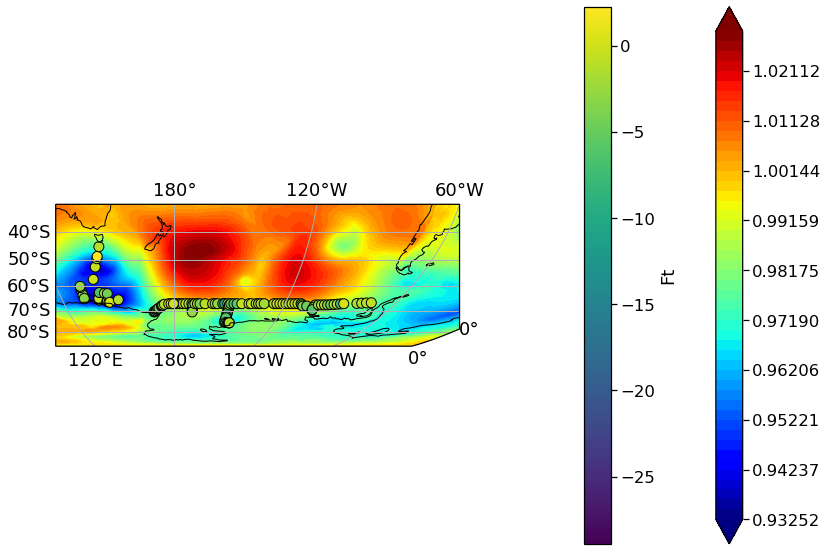

In [154]:
#era = xr.open_dataset("datasets/2017_mean_sea_level_pressure.nc") # local
era21 = xr.open_dataset(f"n2otests/2018_mean_sea_level_pressure.nc") # Poseidon
lon1D = era21['longitude'][:].values
lat1D = era21['latitude'][:].values
time1D = era21['time'][:].values

lon2D, lat2D = np.meshgrid(lat1D, lon1D, indexing='ij')

msl2D = era21.sel(time='2018-03-18 18:00:00').msl
msl2D = msl2D/101325.0 # convert from Pa to atm

msllevs = np.linspace(msl2D.min(),msl2D.max())

fig = plt.figure(figsize=[12, 8]) #figsize=fig dimension (width, height) in inches
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-180))

cmesh = ax.contourf(lat2D, lon2D, msl2D, msllevs, cmap='jet', extend='both',
           transform=ccrs.PlateCarree())

cax = plt.scatter(x=surface["LONGITUDE"],y=surface["LATITUDE"],
                  c=surface["Ft"],
                  #alpha = 0.5,
                  s=100, #marker size
                  edgecolor = 'k',
                  label = None,
                  #norm=colors.PowerNorm(gamma=0.5),
                  transform=ccrs.PlateCarree())

cbar = fig.colorbar(cmesh, location='right')
cbar = fig.colorbar(cax, pad = 0.2).set_label(r'Ft')
#cax.set_clim([0,34])
ax.set_extent([-230, -60, -90, -30], ccrs.PlateCarree()) #can adjust these lat/long to change range of map
ax.gridlines(draw_labels=True)
ax.coastlines(color='black',facecolor='gray')

plt.tight_layout()
plt.show()